## Pip Installs
You should really install these.

In [1]:
%%capture
!pip install beautifulsoup4 yfinance torch alpaca-trade-api alpaca-py

In [2]:
%%capture
!pip install "stable-baselines3[extra]" sb3-contrib gym pandas numpy matplotlib "shimmy>=2.0"

In [3]:
%%capture
!pip install python-dotenv

## SEED (Set Before Trading Env)
Set the initial seed and environment.

In [12]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import numpy as np
import random
import torch

# Fix all seeds
SEED = 83819
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

## Main Logic (Initialize)

Where the technical indicators reside.

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import requests
from bs4 import BeautifulSoup
import re
import io
from PIL import Image
import math
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

DEBUG = True
def debug_print(msg):
    if DEBUG:
        print(msg)

In [14]:
# FOMC Dates Scraper
def get_fomc_dates(start_date, end_date):
    url = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            debug_print(f"Error: Received status code {response.status_code}")
            return []
        soup = BeautifulSoup(response.text, "html.parser")
        date_objs = []
        for text in soup.stripped_strings:
            matches = re.findall(r'([A-Za-z]+ \d{1,2}, \d{4})', text)
            for date_str in matches:
                try:
                    dt = datetime.strptime(date_str, "%B %d, %Y")
                    if dt not in date_objs:
                        date_objs.append(dt)
                except Exception:
                    continue
        date_objs = sorted(date_objs)
        start_dt = pd.to_datetime(start_date)
        end_dt = pd.to_datetime(end_date)
        filtered_dates = [dt for dt in date_objs if start_dt <= dt <= end_dt]
        return filtered_dates
    except Exception as e:
        debug_print(f"Error scraping FOMC dates: {e}")
        return []

In [15]:
# Indicator Functions
def exp_average(series, period):
    return series.ewm(span=period, adjust=False).mean()

def wilder_average(series, length):
    return series.ewm(alpha=1/length, adjust=False).mean()

def weighted_moving_average(series, window):
    weights = np.arange(1, window+1)
    return series.rolling(window).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def t3(source, length=21, vf=0.7):
    ema1 = exp_average(source, length)
    ema2 = exp_average(ema1, length)
    gd1 = ema1*(1+vf) - ema2*vf
    ema11 = exp_average(gd1, length)
    ema22 = exp_average(ema11, length)
    gd2 = ema11*(1+vf) - ema22*vf
    ema111 = exp_average(gd2, length)
    ema222 = exp_average(ema111, length)
    gd3 = ema111*(1+vf) - ema222*vf
    return gd3

def vwma(series, window, volume):
    return (series*volume).rolling(window=window, min_periods=window).sum()/volume.rolling(window=window, min_periods=window).sum()

def rsi_function(close, sensitivity, rsiPeriod, rsiBase):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsiPeriod, min_periods=rsiPeriod).mean()
    avg_loss = loss.rolling(window=rsiPeriod, min_periods=rsiPeriod).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100/(1+rs))
    rsi = rsi.fillna(50)
    rsi_adj = sensitivity*(rsi-rsiBase)
    return rsi_adj.clip(lower=0, upper=20)

def download_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0].lower() for col in df.columns]
    else:
        df.columns = [str(col).lower() for col in df.columns]
    return df

def compute_bressert(df, n_period=8, r_period=13):
    df['Ln'] = df['low'].rolling(window=n_period, min_periods=1).min()
    df['Hn'] = df['high'].rolling(window=n_period, min_periods=1).max()
    df['Y'] = ((df['close']-df['Ln'])/(df['Hn']-df['Ln']))*100
    df['X'] = exp_average(df['Y'], r_period)
    df['Lxn'] = df['X'].rolling(window=n_period, min_periods=1).min()
    df['Hxn'] = df['X'].rolling(window=n_period, min_periods=1).max()
    df['DSS'] = ((df['X']-df['Lxn'])/(df['Hxn']-df['Lxn']))*100
    df['DSSb'] = exp_average(df['DSS'], r_period)
    df['DSSsignal'] = df['DSSb'].shift(1)
    return df

def compute_zscore(df, length_m=14):
    momentum = df['close'] - df['close'].shift(length_m)
    avgMomentum = momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdDevMomentum = momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    zScore = (momentum - avgMomentum)/stdDevMomentum
    return zScore

def compute_zero_lag_macd(source, fastLength=12, slowLength=26, signalLength=9, MacdEmaLength=9, useEma=True, useOldAlgo=False):
    if useEma:
        ma1 = source.ewm(span=fastLength, adjust=False).mean()
        ma2 = ma1.ewm(span=fastLength, adjust=False).mean()
    else:
        ma1 = source.rolling(window=fastLength, min_periods=fastLength).mean()
        ma2 = ma1.rolling(window=fastLength, min_periods=fastLength).mean()
    zerolagEMA = (2*ma1) - ma2
    if useEma:
        mas1 = source.ewm(span=slowLength, adjust=False).mean()
        mas2 = mas1.ewm(span=slowLength, adjust=False).mean()
    else:
        mas1 = source.rolling(window=slowLength, min_periods=slowLength).mean()
        mas2 = mas1.rolling(window=slowLength, min_periods=slowLength).mean()
    zerolagslowMA = (2*mas1) - mas2
    ZeroLagMACD = zerolagEMA - zerolagslowMA
    emasig1 = ZeroLagMACD.ewm(span=signalLength, adjust=False).mean()
    emasig2 = emasig1.ewm(span=signalLength, adjust=False).mean()
    if useOldAlgo:
        signal = ZeroLagMACD.rolling(window=signalLength, min_periods=signalLength).mean()
    else:
        signal = (2*emasig1) - emasig2
    hist = ZeroLagMACD - signal
    upHist = hist.copy()
    upHist[hist <= 0] = 0
    downHist = hist.copy()
    downHist[hist > 0] = 0
    EMALine = ZeroLagMACD.ewm(span=MacdEmaLength, adjust=False).mean()
    dotUP = ZeroLagMACD.copy()
    dotUP[(ZeroLagMACD.shift(1) >= signal.shift(1)) | (ZeroLagMACD < signal)] = np.nan
    dotDN = ZeroLagMACD.copy()
    dotDN[(ZeroLagMACD.shift(1) <= signal.shift(1)) | (ZeroLagMACD > signal)] = np.nan
    return {
        "ZeroLagMACD": ZeroLagMACD,
        "signal": signal,
        "hist": hist,
        "upHist": upHist,
        "downHist": downHist,
        "EMALine": EMALine,
        "dotUP": dotUP,
        "dotDN": dotDN
    }

def compute_basic_macd(source, fast=12, slow=26, signal=9):
    ema_fast = source.ewm(span=fast, adjust=False).mean()
    ema_slow = source.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist_line = macd_line - signal_line
    return {
        "basicMACD": macd_line,
        "signal": signal_line,
        "hist": hist_line
    }

In [16]:
# Historical Signals Extraction
def extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
                    upSig_MCDX, dnSig_MCDX, length_m=14):
    """
    Combines ZLMA, RSI, MCDX, DSS signals in a single table.
    """
    signals = []
    zScore = compute_zscore(df, length_m)

    # ZLMA
    for dt in df.index[signalUp_ZLMA.fillna(False)]:
        signals.append({
            "Date": dt.strftime("%Y-%m-%d"),
            "Signal": "ZLMA Buy",
            "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    for dt in df.index[signalDn_ZLMA.fillna(False)]:
        signals.append({
            "Date": dt.strftime("%Y-%m-%d"),
            "Signal": "ZLMA Sell",
            "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    # RSI
    if isinstance(bullPt, pd.Series):
        for dt in bullPt.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "RSI Buy",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    if isinstance(bearPt, pd.Series):
        for dt in bearPt.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "RSI Sell",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    # MCDX
    if isinstance(upSig_MCDX, pd.Series):
        for dt in upSig_MCDX.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "MCDX Buy",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
            })
    if isinstance(dnSig_MCDX, pd.Series):
        for dt in dnSig_MCDX.dropna().index:
            signals.append({
                "Date": dt.strftime("%Y-%m-%d"),
                "Signal": "MCDX Sell",
                "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
        })
    # DSS
    for i in range(1, len(df)):
        if (pd.notna(df['DSSb'].iloc[i]) and pd.notna(df['DSSsignal'].iloc[i]) and
            pd.notna(df['DSSb'].iloc[i-1]) and pd.notna(df['DSSsignal'].iloc[i-1])):
            if df['DSSb'].iloc[i] > df['DSSsignal'].iloc[i] and df['DSSb'].iloc[i-1] <= df['DSSsignal'].iloc[i-1]:
                dt = df.index[i]
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "DSS Buy",
                    "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
                })
            elif df['DSSb'].iloc[i] < df['DSSsignal'].iloc[i] and df['DSSb'].iloc[i-1] >= df['DSSsignal'].iloc[i-1]:
                dt = df.index[i]
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "DSS Sell",
                    "Z-Score": round(zScore.loc[dt],2) if not pd.isna(zScore.loc[dt]) else None
                })

    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_momentum_signals(df, length_m=14):
    """
    Momentum-based signals. Checks momentum grade changes, direction changes, and state changes.
    """
    momentum = df['close'] - df['close'].shift(length_m)
    avgMomentum = momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdDevMomentum = momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    zScore = (momentum - avgMomentum) / stdDevMomentum

    def grade(x):
        if x >= 2:
            return "A"
        elif x >= 1:
            return "B"
        elif x >= 0:
            return "C"
        elif x >= -1:
            return "D"
        elif x >= -2:
            return "E"
        else:
            return "F"

    momentum_grade = zScore.apply(grade)
    momentum_direction = momentum.apply(lambda x: "Increasing" if x>0 else "Decreasing")

    momentum_state = []
    for i in range(len(momentum)):
        if i == 0:
            momentum_state.append("N/A")
        else:
            if abs(momentum.iloc[i]) < abs(momentum.iloc[i-1]) * 0.0001:
                momentum_state.append("Consolidating")
            elif momentum.iloc[i] * momentum.iloc[i-1] < 0:
                if momentum.iloc[i] > 0:
                    momentum_state.append("Turning Up")
                else:
                    momentum_state.append("Turning Down")
            elif (momentum.iloc[i] > 0 and (momentum.iloc[i] - momentum.iloc[i-1]) < 0) or (momentum.iloc[i] < 0 and (momentum.iloc[i] - momentum.iloc[i-1]) > 0):
                momentum_state.append("Stalling")
            elif momentum.iloc[i] > 0:
                momentum_state.append("Positive Trending")
            else:
                momentum_state.append("Negative Trending")
    momentum_state = pd.Series(momentum_state, index=df.index)

    signals = []
    for i in range(1, len(df)):
        # Grade
        if momentum_grade.iloc[i] != momentum_grade.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum Grade Changed to {momentum_grade.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
        # Direction
        if momentum_direction.iloc[i] != momentum_direction.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum Direction Changed to {momentum_direction.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
        # State
        if momentum_state.iloc[i] != momentum_state.iloc[i-1]:
            signals.append({
                "Date": df.index[i].strftime("%Y-%m-%d"),
                "Signal": f"Momentum State Changed to {momentum_state.iloc[i]}",
                "Z-Score": round(zScore.iloc[i],2)
            })
    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_zero_macd_signals(df, zero_macd_dict, length_m=14):
    macd_line = zero_macd_dict["ZeroLagMACD"]
    macd_mean = macd_line.rolling(window=length_m, min_periods=length_m).mean()
    macd_std = macd_line.rolling(window=length_m, min_periods=length_m).std().replace(0, np.nan)
    macd_zscore = (macd_line - macd_mean)/macd_std

    signals = []
    for i in range(1, len(df)):
        if (pd.notna(zero_macd_dict["ZeroLagMACD"].iloc[i]) and
            pd.notna(zero_macd_dict["signal"].iloc[i]) and
            pd.notna(zero_macd_dict["ZeroLagMACD"].iloc[i-1]) and
            pd.notna(zero_macd_dict["signal"].iloc[i-1])):
            dt = df.index[i]
            if zero_macd_dict["ZeroLagMACD"].iloc[i] > zero_macd_dict["signal"].iloc[i] and zero_macd_dict["ZeroLagMACD"].iloc[i-1] <= zero_macd_dict["signal"].iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "ZeroLag MACD Buy",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
            elif zero_macd_dict["ZeroLagMACD"].iloc[i] < zero_macd_dict["signal"].iloc[i] and zero_macd_dict["ZeroLagMACD"].iloc[i-1] >= zero_macd_dict["signal"].iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "ZeroLag MACD Sell",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
    signals_df = pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"] = pd.to_datetime(signals_df["Date"])
        signals_df = signals_df.sort_values("Date", ascending=False)
    return signals_df

def extract_basic_macd_signals(df, basic_macd_dict, length_m=14):
    macd_line   = basic_macd_dict["basicMACD"]
    signal_line = basic_macd_dict["signal"]
    macd_mean   = macd_line.rolling(window=length_m, min_periods=length_m).mean()
    macd_std    = macd_line.rolling(window=length_m, min_periods=length_m).std().replace(0, np.nan)
    macd_zscore = (macd_line - macd_mean)/macd_std

    signals=[]
    for i in range(1, len(df)):
        if (pd.notna(macd_line.iloc[i]) and pd.notna(signal_line.iloc[i]) and
            pd.notna(macd_line.iloc[i-1]) and pd.notna(signal_line.iloc[i-1])):
            dt= df.index[i]
            # cross up
            if macd_line.iloc[i]> signal_line.iloc[i] and macd_line.iloc[i-1]<= signal_line.iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "Basic MACD Buy",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
            # cross down
            elif macd_line.iloc[i]< signal_line.iloc[i] and macd_line.iloc[i-1]>= signal_line.iloc[i-1]:
                signals.append({
                    "Date": dt.strftime("%Y-%m-%d"),
                    "Signal": "Basic MACD Sell",
                    "Z-Score": round(macd_zscore.iloc[i],2) if not pd.isna(macd_zscore.iloc[i]) else None
                })
    signals_df= pd.DataFrame(signals)
    if not signals_df.empty:
        signals_df["Date"]= pd.to_datetime(signals_df["Date"])
        signals_df= signals_df.sort_values("Date", ascending=False)
    return signals_df

In [17]:
# RSI and MCDX signals
def calc_rsi_entire_series(df, bullPt, bearPt):
    rsi_series = []
    last_signal = "Sell"
    for i in range(len(df)):
        if isinstance(bullPt, pd.Series) and pd.notna(bullPt.iloc[i]):
            last_signal = "Buy"
        elif isinstance(bearPt, pd.Series) and pd.notna(bearPt.iloc[i]):
            last_signal = "Sell"
        rsi_series.append(last_signal)
    return pd.Series(rsi_series, index=df.index)

def calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX):
    mcdx_series = []
    last_signal = "Sell"
    for i in range(len(df)):
        if pd.notna(upSig_MCDX.iloc[i]):
            last_signal = "Buy"
        elif pd.notna(dnSig_MCDX.iloc[i]):
            last_signal = "Sell"
        mcdx_series.append(last_signal)
    return pd.Series(mcdx_series, index=df.index)

In [18]:
# Weighted scoreboard
def scoreboard_for_day(
    df, i,
    rsi_series, mcdx_series,
    zero_macd_dict, basic_macd_dict,
    length_m=14,
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    # ZLMA => Buy if zlma>ema_value
    zlma_status= "Buy" if df['zlma'].iloc[i]> df['ema_value'].iloc[i] else "Sell"
    # RSI => from daily rsi_series
    rsi_status= rsi_series.iloc[i]
    # MCDX => from daily mcdx_series
    mcdx_status= mcdx_series.iloc[i]
    # DSS => Buy if DSSb>DSSsignal
    dss_status= "Buy" if df['DSSb'].iloc[i]> df['DSSsignal'].iloc[i] else "Sell"

    # Z-Score => positive => Buy
    zVal= compute_zscore(df, length_m).iloc[i]
    z_status= "Buy" if zVal>=0 else "Sell"

    # Momentum Grade
    momentum= df['close']- df['close'].shift(length_m)
    avgM= momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdM= momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    z_m= (momentum-avgM)/stdM
    mg_z= z_m.iloc[i] if not pd.isna(z_m.iloc[i]) else 0
    if mg_z>=2:
        mg_grade="A"
    elif mg_z>=1:
        mg_grade="B"
    elif mg_z>=0:
        mg_grade="C"
    elif mg_z>=-1:
        mg_grade="D"
    elif mg_z>=-2:
        mg_grade="E"
    else:
        mg_grade="F"
    mg_status= "Buy" if mg_grade in ["A","B","C"] else "Sell"

    # Momentum Direction
    if i==0:
        md_status="Sell"
    else:
        md_status= "Buy" if momentum.iloc[i]> momentum.iloc[i-1] else "Sell"

    # Momentum State
    if i==0:
        ms_val=0
    else:
        val_now= momentum.iloc[i]
        val_prev= momentum.iloc[i-1]
        change= val_now- val_prev
        ms_val=0
        if val_now>0 and val_prev<0:
            ms_val=1
        elif val_now<0 and val_prev>0:
            ms_val=-1
        elif abs(val_now)< abs(avgM.iloc[i])*0.1:
            ms_val=0
        elif (val_now>0 and change<0) or (val_now<0 and change>0):
            ms_val=0
        elif val_now>0:
            ms_val=1
        else:
            ms_val=-1
    if ms_val>0:
        ms_status="Buy"
    elif ms_val<0:
        ms_status="Sell"
    else:
        ms_status="Neutral"

    zero_macd_status="Sell"
    if zero_macd_dict is not None:
        if zero_macd_dict["ZeroLagMACD"].iloc[i]> zero_macd_dict["signal"].iloc[i]:
            zero_macd_status="Buy"
        else:
            zero_macd_status="Sell"

    basic_macd_status="Sell"
    if basic_macd_dict is not None:
        if basic_macd_dict["basicMACD"].iloc[i]> basic_macd_dict["signal"].iloc[i]:
            basic_macd_status="Buy"
        else:
            basic_macd_status="Sell"

    scoreboard=[]
    scoreboard.append(weight_zlma if zlma_status=="Buy" else -weight_zlma)
    scoreboard.append(weight_rsi  if rsi_status=="Buy" else -weight_rsi)
    scoreboard.append(weight_mcdx if mcdx_status=="Buy" else -weight_mcdx)
    scoreboard.append(weight_dss  if dss_status=="Buy" else -weight_dss)
    scoreboard.append(weight_zscore if zVal>=0 else -weight_zscore)
    scoreboard.append(weight_mg if mg_status=="Buy" else -weight_mg)
    scoreboard.append(weight_md if md_status=="Buy" else -weight_md)

    ms_val_weighted=0
    if ms_status=="Buy":
        ms_val_weighted= weight_ms
    elif ms_status=="Sell":
        ms_val_weighted= -weight_ms
    scoreboard.append(ms_val_weighted)

    scoreboard.append(weight_zeromacd if zero_macd_status=="Buy" else -weight_zeromacd)
    scoreboard.append(weight_basicmacd if basic_macd_status=="Buy" else -weight_basicmacd)

    total_signals= sum(1 for x in scoreboard if x!=0)
    bullish_count= sum(1 for x in scoreboard if x>0)

    if total_signals==0:
        return "Neutral"
    else:
        if bullish_count>= (total_signals/2.0):
            return "Buy"
        else:
            return "Sell"

In [19]:
# Historical Trade Table
def simulate_trades_overall_signal(
    df, rsi_series, mcdx_series,
    zero_macd_dict, basic_macd_dict,
    length_m=14,
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    position = 0
    entry_price = 0.0
    trade_log = []
    cumulative_pnl_sum = 0.0
    prev_signal = "Neutral"

    for i in range(len(df)):
        day_signal = scoreboard_for_day(
            df, i, rsi_series, mcdx_series,
            zero_macd_dict, basic_macd_dict,
            length_m,
            weight_zlma, weight_rsi, weight_mcdx, weight_dss,
            weight_zscore, weight_mg, weight_md, weight_ms,
            weight_zeromacd, weight_basicmacd
        )
        price_i = df['close'].iloc[i]
        date_i = df.index[i]

        # Flip from Sell->Buy => close short
        if prev_signal in ["Sell", "Neutral"] and day_signal == "Buy":
            if position == -1:
                exit_price = price_i
                pnl_pct = ((entry_price / exit_price) - 1)*100
                cumulative_pnl_sum += pnl_pct
                trade_log.append({
                    "EntryDate": entry_dt_str,
                    "ExitDate": date_i.strftime("%Y-%m-%d"),
                    "Position": "Short",
                    # Round to 4 decimal places:
                    "EntryPrice": round(entry_price, 4),
                    "ExitPrice": round(exit_price, 4),
                    "PnL%": round(pnl_pct, 2),
                    "CumulativePnL%": round(cumulative_pnl_sum, 2)
                })
                position = 0
            position = 1
            entry_price = price_i
            entry_dt_str = date_i.strftime("%Y-%m-%d")

        # Flip from Buy->Sell => close long
        elif prev_signal in ["Buy", "Neutral"] and day_signal == "Sell":
            if position == 1:
                exit_price = price_i
                pnl_pct = ((exit_price / entry_price) - 1)*100
                cumulative_pnl_sum += pnl_pct
                trade_log.append({
                    "EntryDate": entry_dt_str,
                    "ExitDate": date_i.strftime("%Y-%m-%d"),
                    "Position": "Long",
                    "EntryPrice": round(entry_price, 4),
                    "ExitPrice": round(exit_price, 4),
                    "PnL%": round(pnl_pct, 2),
                    "CumulativePnL%": round(cumulative_pnl_sum, 2)
                })
                position = 0
            position = -1
            entry_price = price_i
            entry_dt_str = date_i.strftime("%Y-%m-%d")

        prev_signal = day_signal

    # Close any open position at the end
    if position != 0:
        final_price = df['close'].iloc[-1]
        final_date = df.index[-1]
        if position == 1:
            exit_price = final_price
            pnl_pct = ((exit_price / entry_price) - 1)*100
            cumulative_pnl_sum += pnl_pct
            trade_log.append({
                "EntryDate": entry_dt_str,
                "ExitDate": final_date.strftime("%Y-%m-%d"),
                "Position": "Long",
                "EntryPrice": round(entry_price, 4),
                "ExitPrice": round(exit_price, 4),
                "PnL%": round(pnl_pct, 2),
                "CumulativePnL%": round(cumulative_pnl_sum, 2)
            })
        else:
            exit_price = final_price
            pnl_pct = ((entry_price / exit_price) - 1)*100
            cumulative_pnl_sum += pnl_pct
            trade_log.append({
                "EntryDate": entry_dt_str,
                "ExitDate": final_date.strftime("%Y-%m-%d"),
                "Position": "Short",
                "EntryPrice": round(entry_price, 4),
                "ExitPrice": round(exit_price, 4),
                "PnL%": round(pnl_pct, 2),
                "CumulativePnL%": round(cumulative_pnl_sum, 2)
            })

    trade_df = pd.DataFrame(trade_log)
    trade_df["ExitDate_dt"] = pd.to_datetime(trade_df["ExitDate"])
    trade_df = trade_df.sort_values("ExitDate_dt", ascending=False).reset_index(drop=True)
    trade_df.drop(columns=["ExitDate_dt"], inplace=True)
    return trade_df

In [20]:
# Scoreboard with ZeroLag + Basic MACD
def extract_current_status(
    df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
    upSig_MCDX, dnSig_MCDX,
    length_m=14,
    zero_macd_dict=None, basic_macd_dict=None,

    # Weighted scoreboard
    weight_zlma=1.0, weight_rsi=1.0, weight_mcdx=1.0, weight_dss=1.0,
    weight_zscore=1.0, weight_mg=1.0, weight_md=1.0, weight_ms=1.0,
    weight_zeromacd=1.0, weight_basicmacd=1.0
):
    i= len(df)-1
    zlma_status= "Buy" if df['zlma'].iloc[i]> df['ema_value'].iloc[i] else "Sell"

    # RSI daily
    daily_rsi_series  = calc_rsi_entire_series(df, bullPt, bearPt)
    rsi_status        = daily_rsi_series.iloc[i]
    # MCDX daily
    daily_mcdx_series = calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
    mcdx_status       = daily_mcdx_series.iloc[i]
    # DSS => buy if DSSb>DSSsignal
    dss_status= "Buy" if df['DSSb'].iloc[i]> df['DSSsignal'].iloc[i] else "Sell"

    # Z-Score
    zVal= compute_zscore(df, length_m).iloc[i]
    z_status= "Buy" if zVal>=0 else "Sell"

    # Momentum
    momentum= df['close']- df['close'].shift(length_m)
    avgM= momentum.rolling(window=length_m, min_periods=length_m).mean()
    stdM= momentum.rolling(window=length_m, min_periods=length_m).std().fillna(0)
    z_m= (momentum-avgM)/ stdM
    mg_z= z_m.iloc[i] if not pd.isna(z_m.iloc[i]) else 0
    if mg_z>=2:
        mg_letter="A"
    elif mg_z>=1:
        mg_letter="B"
    elif mg_z>=0:
        mg_letter="C"
    elif mg_z>=-1:
        mg_letter="D"
    elif mg_z>=-2:
        mg_letter="E"
    else:
        mg_letter="F"
    mg_status= "Buy" if mg_letter in ["A","B","C"] else "Sell"

    # momentum direction
    if i==0:
        md_status="Sell"
    else:
        md_status= "Buy" if momentum.iloc[i]> momentum.iloc[i-1] else "Sell"

    # momentum state
    if i==0:
        ms_val=0
    else:
        val_now= momentum.iloc[i]
        val_prev= momentum.iloc[i-1]
        change= val_now- val_prev
        ms_val=0
        if val_now>0 and val_prev<0:
            ms_val=1
        elif val_now<0 and val_prev>0:
            ms_val=-1
        elif abs(val_now)< abs(avgM.iloc[i])*0.1:
            ms_val=0
        elif (val_now>0 and change<0) or (val_now<0 and change>0):
            ms_val=0
        elif val_now>0:
            ms_val=1
        else:
            ms_val=-1
    if ms_val>0:
        ms_status="Buy"
    elif ms_val<0:
        ms_status="Sell"
    else:
        ms_status="Neutral"

    zero_macd_status= "Sell"
    if zero_macd_dict is not None:
        if zero_macd_dict["ZeroLagMACD"].iloc[i]> zero_macd_dict["signal"].iloc[i]:
            zero_macd_status= "Buy"
        else:
            zero_macd_status= "Sell"

    basic_macd_status="Sell"
    if basic_macd_dict is not None:
        if basic_macd_dict["basicMACD"].iloc[i]> basic_macd_dict["signal"].iloc[i]:
            basic_macd_status= "Buy"
        else:
            basic_macd_status= "Sell"

    scoreboard=[]
    scoreboard.append(weight_zlma if zlma_status=="Buy" else -weight_zlma)
    scoreboard.append(weight_rsi  if rsi_status=="Buy" else -weight_rsi)
    scoreboard.append(weight_mcdx if mcdx_status=="Buy" else -weight_mcdx)
    scoreboard.append(weight_dss  if dss_status=="Buy" else -weight_dss)
    scoreboard.append(weight_zscore if zVal>=0 else -weight_zscore)
    scoreboard.append(weight_mg if mg_status=="Buy" else -weight_mg)
    scoreboard.append(weight_md if md_status=="Buy" else -weight_md)

    ms_val_weighted=0
    if ms_status=="Buy":
        ms_val_weighted= weight_ms
    elif ms_status=="Sell":
        ms_val_weighted= -weight_ms
    scoreboard.append(ms_val_weighted)

    scoreboard.append(weight_zeromacd if zero_macd_status=="Buy" else -weight_zeromacd)
    scoreboard.append(weight_basicmacd if basic_macd_status=="Buy" else -weight_basicmacd)

    total_signals= sum(1 for x in scoreboard if x!=0)
    bullish_count= sum(1 for x in scoreboard if x>0)
    total_score= sum(scoreboard)

    if total_signals==0:
        overall= "Neutral"
    else:
        if bullish_count>= (total_signals/2.0):
            overall= "Buy"
        else:
            overall= "Sell"

    indicators= [
        "ZLMA","RSI","MCDX","DSS","Z-Score",
        "Momentum Grade","Momentum Direction","Momentum State",
        "ZeroLag MACD","Basic MACD","ScoreSum","Overall Trade"
    ]
    signals_=[
        zlma_status,
        rsi_status,
        mcdx_status,
        dss_status,
        round(zVal,2),
        mg_letter,
        ("Increasing" if md_status=="Buy" else "Decreasing"),
        ms_status,
        zero_macd_status,
        basic_macd_status,
        str(round(total_score,2)),
        overall
    ]
    return pd.DataFrame({"Indicator": indicators, "Current Signal": signals_})

In [21]:
# Plot
def create_generic_plot(df, ticker, start_date, end_date,
                        ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
                        rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
                        b_X, b_DSSb, b_DSSsignal,
                        hbma, threshold, upSig_MCDX, dnSig_MCDX,
                        Dump, DnCandle, PumpCandle, Retest, Banker,
                        iv_series, zero_macd_dict, basic_macd_dict=None,
                        momentum_length=14):
    fig, axs = plt.subplots(8,1,sharex=True,figsize=(12,20),
                            gridspec_kw={"height_ratios":[2,1,1,1,1,1,1,1]})
    fig.suptitle(f"{ticker} - Generic Multi-Panel Chart with Momentum & Dual MACD", fontsize=14)
    x_vals = mdates.date2num(df.index.to_pydatetime())

    # Panel 1: Price + ZLMA + RSI + Momentum text
    for i in range(len(df)):
        o, c, h, l = df['open'].iloc[i], df['close'].iloc[i], df['high'].iloc[i], df['low'].iloc[i]
        color= 'green' if c>= o else 'red'
        axs[0].plot([x_vals[i], x_vals[i]], [l,h], color=color, linewidth=1, zorder=1)
        candle_width= 0.6
        axs[0].add_patch(Rectangle((x_vals[i]-candle_width/2, o), candle_width, c-o,
                                   facecolor=color, edgecolor=color, zorder=2))
    axs[0].plot(df.index, df['EMA_50'],  label="EMA 50",  color='blue',   linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_100'], label="EMA 100", color='orange', linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_200'], label="EMA 200", color='purple', linewidth=1.5, zorder=3)
    axs[0].plot(df.index, df['EMA_500'], label="EMA 500", color='brown',  linewidth=1.5, zorder=3)
    axs[0].plot(df.index, ema_value, label="EMA (Trend)", color=ema_color, linewidth=2, zorder=4)
    axs[0].plot(df.index, zlma,      label="ZLMA",        color=zlma_color, linewidth=2, zorder=4)
    axs[0].fill_between(df.index, zlma, ema_value, where=(zlma>=ema_value), facecolor="darkgreen", alpha=0.3, interpolate=True, zorder=3)
    axs[0].fill_between(df.index, zlma, ema_value, where=(zlma<ema_value), facecolor="darkred", alpha=0.3, interpolate=True, zorder=3)
    axs[0].scatter(df.index, zlma.where(signalUp_ZLMA), color="cyan",    marker="o", s=50, label="ZLMA Buy",  zorder=5)
    axs[0].scatter(df.index, zlma.where(signalDn_ZLMA), color="magenta", marker="o", s=50, label="ZLMA Sell", zorder=5)

    axs[0].plot(df.index, rsi_ma_base,     label="RSI Trail Base",  color="gray", linestyle="--", linewidth=1)
    axs[0].plot(df.index, rsi_upper_bound, label="RSI Trail Upper", color="blue", linewidth=1)
    axs[0].plot(df.index, rsi_lower_bound, label="RSI Trail Lower", color="red",  linewidth=1)
    if isinstance(bullPt, pd.Series):
        axs[0].scatter(df.index, bullPt, color="cyan",    marker="^", s=50, label="RSI Buy",  zorder=6)
    if isinstance(bearPt, pd.Series):
        axs[0].scatter(df.index, bearPt, color="magenta", marker="v", s=50, label="RSI Sell", zorder=6)
    axs[0].fill_between(df.index, rsi_ma_base,     rsi_upper_bound, facecolor="darkgreen", alpha=0.2, interpolate=True)
    axs[0].fill_between(df.index, rsi_lower_bound, rsi_ma_base,     facecolor="darkred",   alpha=0.2, interpolate=True)

    fomc_dates= get_fomc_dates(start_date, end_date)
    for i, dt in enumerate(fomc_dates):
        axs[0].axvline(dt, color="purple", linestyle="--", linewidth=1, label="FOMC" if i==0 else "")

    axs[0].set_ylabel("Price")
    # Legend bottom-right
    axs[0].legend(loc="lower right", ncol=3, fontsize=8)

    # Momentum text
    momentum= df['close']- df['close'].shift(momentum_length)
    avgM= momentum.rolling(window=momentum_length, min_periods=momentum_length).mean()
    stdM= momentum.rolling(window=momentum_length, min_periods=momentum_length).std().fillna(0)
    zScore_m= (momentum- avgM)/ stdM
    if len(zScore_m.dropna())>0:
        last_z= zScore_m.iloc[-1]
    else:
        last_z= np.nan
    if not np.isnan(last_z):
        if last_z>=2:
            gradeStr= "A (Strong Positive Momentum)"
            gradeColor= "green"
        elif last_z>=1:
            gradeStr= "B (Moderate Positive Momentum)"
            gradeColor= "lightgreen"
        elif last_z>=0:
            gradeStr= "C (Weak Positive Momentum)"
            gradeColor= "goldenrod"
        elif last_z>=-1:
            gradeStr= "D (Weak Negative Momentum)"
            gradeColor= "orange"
        elif last_z>=-2:
            gradeStr= "E (Moderate Negative Momentum)"
            gradeColor= "red"
        else:
            gradeStr= "F (Strong Negative Momentum)"
            gradeColor= "darkred"
    else:
        gradeStr= "N/A"
        gradeColor= "white"
    if len(df)>1:
        directionIncreasing= (momentum.iloc[-1]> momentum.iloc[-2])
        dirStr= "Increasing" if directionIncreasing else "Decreasing"
        dirColor= "green" if directionIncreasing else "red"
        change= momentum.iloc[-1]- momentum.iloc[-2]
        if momentum.iloc[-1]* momentum.iloc[-2]<0:
            stateStr= "Turning Up" if momentum.iloc[-1]>0 else "Turning Down"
            stateColor= "orange"
        elif abs(momentum.iloc[-1])< abs(avgM.iloc[-1])*0.1:
            stateStr= "Consolidating"
            stateColor= "yellow"
        elif (momentum.iloc[-1]>0 and change<0) or (momentum.iloc[-1]<0 and change>0):
            stateStr= "Stalling"
            stateColor= "lightgray"
        elif momentum.iloc[-1]>0:
            stateStr= "Positive Trending"
            stateColor= "green"
        else:
            stateStr= "Negative Trending"
            stateColor= "red"
    else:
        dirStr, dirColor= "N/A","white"
        stateStr, stateColor= "N/A","white"

    axs[0].text(0.01,0.95, f"Momentum Grade: {gradeStr} (Z-Score: {last_z:.2f})",
                transform= axs[0].transAxes, fontsize=10, color= gradeColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].text(0.01,0.90, f"Momentum Direction: {dirStr}",
                transform= axs[0].transAxes, fontsize=10, color= dirColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    axs[0].text(0.01,0.85, f"Momentum State: {stateStr}",
                transform= axs[0].transAxes, fontsize=10, color= stateColor,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Panel 2: Bressert
    axs[1].plot(df.index, b_X, label="X (EMA of Y)", color="black", linewidth=2)
    marker_colors= ['black']+ ['red' if b_X.iloc[i]< b_X.iloc[i-1] else 'green' for i in range(1,len(b_X))]
    axs[1].scatter(df.index, b_X, c=marker_colors, s=20)
    axs[1].plot(df.index, b_DSSb,       label="DSSb",       color="blue",    linewidth=2)
    axs[1].plot(df.index, b_DSSsignal,  label="DSSsignal",  color="magenta", linewidth=2)
    axs[1].axhline(50, color="gray", linewidth=1)
    axs[1].axhline(80, color="red",  linewidth=2)
    axs[1].axhline(20, color="green",linewidth=2)
    axs[1].set_ylabel("Bressert")
    axs[1].legend(loc="lower left", fontsize=8)

    # Panel 3: MCDX HBMA & Signals
    axs[2].plot(df.index, hbma, label="HBMA", color="black", linewidth=2, zorder=3)
    axs[2].axhline(threshold, color="gray", linestyle="--", label="Threshold", zorder=2)
    axs[2].scatter(df.index, upSig_MCDX, color="green", marker="o", s=50, label="MCDX Buy",  zorder=4)
    axs[2].scatter(df.index, dnSig_MCDX, color="red",   marker="o", s=50, label="MCDX Sell", zorder=4)
    axs[2].set_ylabel("MCDX HBMA")
    axs[2].legend(loc="lower left", fontsize=8)

    # Panel 4: MCDX Bars
    axs[3].bar(df.index, Dump,       width=0.8, color="red",      alpha=0.7, label="Dump",        zorder=1)
    axs[3].bar(df.index, DnCandle,   width=0.8, color="darkgray", alpha=0.7, label="Down Candle", zorder=1)
    axs[3].bar(df.index, PumpCandle, width=0.8, color="green",    alpha=0.7, label="Pump Candle", zorder=1)
    axs[3].bar(df.index, Retest,     width=0.8, color="darkred",  alpha=0.7, label="Retest",      zorder=1)
    axs[3].bar(df.index, Banker,     width=0.8, color="#84AFC9",  alpha=0.7, label="Banker",      zorder=1)
    axs[3].set_ylabel("MCDX Bars")
    axs[3].legend(loc="lower left", fontsize=8)

    # Panel 5: Zero Lag MACD
    zmacd= zero_macd_dict
    axs[4].fill_between(df.index, zmacd["ZeroLagMACD"], zmacd["signal"],
                        where=(zmacd["ZeroLagMACD"]>= zmacd["signal"]),
                        facecolor="green", alpha=0.3, interpolate=True)
    axs[4].fill_between(df.index, zmacd["ZeroLagMACD"], zmacd["signal"],
                        where=(zmacd["ZeroLagMACD"]< zmacd["signal"]),
                        facecolor="red", alpha=0.3, interpolate=True)
    axs[4].plot(df.index, zmacd["ZeroLagMACD"], label="ZeroLag MACD", color="green", linewidth=1)
    axs[4].plot(df.index, zmacd["signal"],      label="ZMACD Signal", color="red",   linewidth=1)
    axs[4].bar(df.index, zmacd["upHist"]*2,   label="ZMACD Hist Up",   color="gray", width=0.8)
    axs[4].bar(df.index, zmacd["downHist"]*2, label="ZMACD Hist Down", color="red",  width=0.8)
    axs[4].scatter(df.index, zmacd["dotUP"], color="green", marker="o", s=50, label="ZMACD Dot Up")
    axs[4].scatter(df.index, zmacd["dotDN"], color="red",   marker="o", s=50, label="ZMACD Dot Down")
    axs[4].set_ylabel("ZeroLag MACD")
    axs[4].legend(loc="lower left", fontsize=8)

    # Panel 6: VIX
    axs[5].plot(df.index, iv_series, label="VIX", color="darkorange", linewidth=2)
    axs[5].set_ylabel("IV")
    axs[5].legend(loc="lower left", fontsize=8)
    axs[5].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    for tick in axs[5].get_xticklabels():
        tick.set_rotation(45)

    # Panel 7: Momentum Z-Score
    zScore_panel= compute_zscore(df, momentum_length)
    axs[6].axhline(0, color="gray", linestyle="--")
    axs[6].fill_between(df.index, zScore_panel, 0, where=(zScore_panel>0), facecolor="green", alpha=0.3)
    axs[6].fill_between(df.index, zScore_panel, 0, where=(zScore_panel<0), facecolor="red", alpha=0.3)
    axs[6].plot(df.index, zScore_panel, label="Momentum Z-Score", color="black", linewidth=1.5)
    axs[6].set_ylabel("Momentum")
    axs[6].legend(loc="lower left", fontsize=8)

    # Panel 8: Basic MACD
    if basic_macd_dict:
        macd_line= basic_macd_dict["basicMACD"]
        sig_line=  basic_macd_dict["signal"]
        hist_line= basic_macd_dict["hist"]
        axs[7].fill_between(df.index, macd_line, sig_line,
                            where=(macd_line>= sig_line),
                            facecolor="green", alpha=0.3, interpolate=True)
        axs[7].fill_between(df.index, macd_line, sig_line,
                            where=(macd_line< sig_line),
                            facecolor="red", alpha=0.3, interpolate=True)
        axs[7].plot(df.index, macd_line, label="Basic MACD", color="green", linewidth=1)
        axs[7].plot(df.index, sig_line,  label="Basic MACD Signal", color="red", linewidth=1)
        axs[7].bar(df.index, hist_line*2, label="Basic MACD Hist", color="gray", width=0.8)
        axs[7].set_ylabel("Basic MACD")
        axs[7].legend(loc="lower left", fontsize=8)
    else:
        axs[7].text(0.5,0.5, "No Basic MACD Data", ha="center", va="center", transform=axs[7].transAxes)
        axs[7].set_ylabel("Basic MACD")

    plt.tight_layout()
    return fig

def figure_to_pil(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    return Image.open(buf)

In [22]:
# Main chart function and trade log
def generate_plot(
    ticker="SPY",
    start_date="2022-01-01",
    end_date="2023-01-01",

    # Weighted scoreboard
    weight_zlma=1.0,
    weight_rsi=1.0,
    weight_mcdx=1.0,
    weight_dss=1.0,
    weight_zscore=1.0,
    weight_mg=1.0,
    weight_md=1.0,
    weight_ms=1.0,

    # Two MACD weights
    weight_zeromacd=1.0,
    weight_basicmacd=1.0
):
    try:
        df = download_data(ticker, start_date, end_date)
        if df.empty:
            raise gr.Error(f"No data for {ticker} from {start_date} to {end_date}")
        for col in ["open","high","low","close","volume"]:
            if col not in df.columns:
                raise gr.Error(f"Missing {col} data for {ticker}")

        # Basic EMAs
        df['EMA_50'] = exp_average(df['close'], 50)
        df['EMA_100']= exp_average(df['close'], 100)
        df['EMA_200']= exp_average(df['close'], 200)
        df['EMA_500']= exp_average(df['close'], 500)

        # ZLMA
        movAvgLength= 15
        ema_value= exp_average(df['close'], movAvgLength)
        df['ema_value']= ema_value
        correction= df['close']+(df['close']-ema_value)
        zlma= exp_average(correction, movAvgLength)
        df['zlma']= zlma

        signalUp_ZLMA= (zlma>ema_value)&(zlma.shift(1)<= ema_value.shift(1))
        signalDn_ZLMA= (zlma<ema_value)&(zlma.shift(1)>= ema_value.shift(1))
        zlma_color= "green" if zlma.iloc[-1]> zlma.iloc[-2] else "red"
        ema_color=  "green" if ema_value.iloc[-1]< zlma.iloc[-1] else "red"

        # Bressert
        df= compute_bressert(df,8,13)
        b_X= df['X']
        b_DSSb= df['DSSb']
        b_DSSsignal= df['DSSsignal']

        # MCDX + RSI
        RSIBaseBanker= 50;   RSIPeriodBanker= 50
        RSIBaseHotMoney=30; RSIPeriodHotMoney= 40
        SensitivityBanker=1.5; SensitivityHotMoney=0.7
        threshold= 8.5

        rsi_Banker= rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
        rsi_HotMoney= rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)
        hot= rsi_HotMoney
        bank= rsi_Banker
        hotma2= wilder_average(hot,2)
        hotma7= wilder_average(hot,7)
        hotma31= wilder_average(hot,31)
        hotma= exp_average((hotma2*34 + hotma7*33 + hotma31*33)/100,2)
        bankma2= df['close'].rolling(window=2, min_periods=2).mean()
        bankma7= exp_average(bank,7)
        bankma31=exp_average(bank,31)
        bankma= ((bankma2*70 + bankma7*20 + bankma31*10)/100).rolling(window=2, min_periods=2).mean()
        banksignal= wilder_average(bankma,4)
        df['banksignal']= banksignal

        hbAvg= ((hot*10)+(hotma*35)+(wilder_average(hotma,2)*15)+(bankma*35)+(banksignal*5))/100
        hbma= vwma(hbAvg,2, df['volume'])
        df['hbma']= hbma

        downtrendsignal= (hotma.shift(1)>= wilder_average(hotma,2).shift(1))&(hotma< wilder_average(hotma,2))
        uptrendsignal=   (hotma.shift(1)<= wilder_average(hotma,2).shift(1))&(hotma> wilder_average(hotma,2))
        upSig_MCDX= hbma.where(uptrendsignal,   np.nan)
        dnSig_MCDX= hbma.where(downtrendsignal, np.nan)

        Dump= bank.where(bank< bank.shift(1)/1.75, np.nan)
        dnCond= (bank<bank.shift(1))&(bank<bank.shift(2))&(bank.shift(1)<bank.shift(2))& \
                (bank<bank.shift(3))&(bank<bank.shift(4))&(bank.shift(3)<bank.shift(4))& \
                (bank.shift(6)>8.5)&(bank<10)
        DnCandle=   bank.where(dnCond, np.nan)
        PumpCandle= bank.where(bank> hbma, np.nan)
        Retest=     bank.where((banksignal> bankma)&(bank>0), np.nan)
        Banker=     bank

        # RSI trail
        lookbackPeriod=15
        atrLength=27
        atrMultiplier=0.1
        rsiLowerThreshold=40
        rsiUpperThreshold=60
        ohlc4= (df['open']+df['high']+df['low']+df['close'])/4
        rsi_ma_base= t3(ohlc4, length=lookbackPeriod, vf=0.7)
        df['rsi_ma_base']= rsi_ma_base
        tr_series= pd.concat([
            df['high']-df['low'],
            abs(df['high']-df['close'].shift(1)),
            abs(df['low']-df['close'].shift(1))
        ], axis=1).max(axis=1)
        nzTR= tr_series.fillna(df['high']-df['low'])
        f_volatility= wilder_average(nzTR,atrLength)* atrMultiplier
        rsi_upper_bound= rsi_ma_base+ ((rsiUpperThreshold-50)/10)* f_volatility
        rsi_lower_bound= rsi_ma_base- ((50-rsiLowerThreshold)/10)* f_volatility

        crossUp= (ohlc4> rsi_upper_bound)&(ohlc4.shift(1)<= rsi_upper_bound.shift(1))
        crossDn= (df['close']<rsi_lower_bound)&(df['close'].shift(1)>= rsi_lower_bound.shift(1))
        bullPt=   rsi_lower_bound.where(crossUp, np.nan)
        bearPt=   rsi_upper_bound.where(crossDn, np.nan)

        # VIX => iv_series
        vix_df= yf.download("^VIX", start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
        if vix_df.empty:
            iv_series= pd.Series(np.nan, index=df.index)
        else:
            vix_df.index= pd.to_datetime(vix_df.index)
            iv_series= vix_df["Close"].reindex(df.index, method="ffill")

        # ZeroLag MACD
        zero_macd_dict= compute_zero_lag_macd(df['close'], fastLength=12, slowLength=26, signalLength=9,
                                              MacdEmaLength=9, useEma=True, useOldAlgo=False)

        # Basic MACD
        # basic_macd_dict= compute_basic_macd(df['close'], fast=12, slow=26, signal=9)
        basic_macd_dict= compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

        # Create multi-panel figure
        fig= create_generic_plot(
            df, ticker, start_date, end_date,
            ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
            rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
            b_X, b_DSSb, b_DSSsignal,
            hbma, threshold, upSig_MCDX, dnSig_MCDX,
            Dump, DnCandle, PumpCandle, Retest, Banker,
            iv_series, zero_macd_dict, basic_macd_dict,
            momentum_length=14
        )

        # Build historical signals
        signals_zmacd_df= extract_zero_macd_signals(df, zero_macd_dict, length_m=14)
        signals_bmacd_df= extract_basic_macd_signals(df, basic_macd_dict, length_m=14)
        signals_others_df= extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
                                           upSig_MCDX, dnSig_MCDX, length_m=14)
        momentum_signals_df= extract_momentum_signals(df, length_m=14)
        historical_signals_df= pd.concat([
            signals_others_df,
            momentum_signals_df,
            signals_zmacd_df,
            signals_bmacd_df
        ], ignore_index=True)
        if not historical_signals_df.empty:
            historical_signals_df["Date"]= pd.to_datetime(historical_signals_df["Date"])
            historical_signals_df= historical_signals_df.sort_values("Date", ascending=False)

        # Current scoreboard
        current_status_df= extract_current_status(
            df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt,
            upSig_MCDX, dnSig_MCDX,
            length_m=14,
            zero_macd_dict= zero_macd_dict,
            basic_macd_dict= basic_macd_dict,
            weight_zlma= weight_zlma,
            weight_rsi= weight_rsi,
            weight_mcdx= weight_mcdx,
            weight_dss= weight_dss,
            weight_zscore= weight_zscore,
            weight_mg= weight_mg,
            weight_md= weight_md,
            weight_ms= weight_ms,
            weight_zeromacd= weight_zeromacd,
            weight_basicmacd= weight_basicmacd
        )

        # Day-by-day scoreboard => trade log
        daily_rsi_series= calc_rsi_entire_series(df, bullPt, bearPt)
        daily_mcdx_series= calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
        trade_log_df= simulate_trades_overall_signal(
            df, daily_rsi_series, daily_mcdx_series,
            zero_macd_dict, basic_macd_dict,
            length_m=14,
            weight_zlma= weight_zlma,
            weight_rsi= weight_rsi,
            weight_mcdx= weight_mcdx,
            weight_dss= weight_dss,
            weight_zscore= weight_zscore,
            weight_mg= weight_mg,
            weight_md= weight_md,
            weight_ms= weight_ms,
            weight_zeromacd= weight_zeromacd,
            weight_basicmacd= weight_basicmacd
        )

        buf= io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        pil_img= Image.open(buf)
        plt.close(fig)

        return pil_img, current_status_df, historical_signals_df, trade_log_df
    except Exception as e:
        debug_print(f"Error: {e}")
        raise gr.Error(f"An error occurred: {e}")

In [23]:
def save_historical_data(ticker="SPY", start_date="2022-01-01", end_date="2023-01-01",
                         data_filename="full_data.csv", signals_filename="signals_data.csv"):
    try:
        df = download_data(ticker, start_date, end_date)
        if df.empty:
            raise gr.Error(f"No data for {ticker} from {start_date} to {end_date}")

        # --- Basic EMAs and ZLMA ---
        df['EMA_50'] = exp_average(df['close'], 50)
        df['EMA_100'] = exp_average(df['close'], 100)
        df['EMA_200'] = exp_average(df['close'], 200)
        df['EMA_500'] = exp_average(df['close'], 500)

        movAvgLength = 15
        df['ema_value'] = exp_average(df['close'], movAvgLength)
        correction = df['close'] + (df['close'] - df['ema_value'])
        df['zlma'] = exp_average(correction, movAvgLength)

        signalUp_ZLMA = (df['zlma'] > df['ema_value']) & (df['zlma'].shift(1) <= df['ema_value'].shift(1))
        signalDn_ZLMA = (df['zlma'] < df['ema_value']) & (df['zlma'].shift(1) >= df['ema_value'].shift(1))

        # --- Bressert DSS ---
        df = compute_bressert(df, 8, 13)

        # --- MCDX ---
        RSIBaseBanker = 50; RSIPeriodBanker = 50
        RSIBaseHotMoney = 30; RSIPeriodHotMoney = 40
        SensitivityBanker = 1.5; SensitivityHotMoney = 0.7
        rsi_Banker = rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
        rsi_HotMoney = rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)

        hot = rsi_HotMoney
        bank = rsi_Banker
        hotma2 = wilder_average(hot, 2)
        hotma7 = wilder_average(hot, 7)
        hotma31 = wilder_average(hot, 31)
        hotma = exp_average((hotma2 * 34 + hotma7 * 33 + hotma31 * 33) / 100, 2)

        bankma2 = df['close'].rolling(window=2).mean()
        bankma7 = exp_average(bank, 7)
        bankma31 = exp_average(bank, 31)
        bankma = ((bankma2 * 70 + bankma7 * 20 + bankma31 * 10) / 100).rolling(window=2).mean()
        banksignal = wilder_average(bankma, 4)
        df['banksignal'] = banksignal

        hbAvg = ((hot * 10) + (hotma * 35) + (wilder_average(hotma, 2) * 15) + (bankma * 35) + (banksignal * 5)) / 100
        df['hbma'] = vwma(hbAvg, 2, df['volume'])

        hotma_slow = wilder_average(hotma, 2)
        uptrendsignal = (hotma.shift(1) <= hotma_slow.shift(1)) & (hotma > hotma_slow)
        downtrendsignal = (hotma.shift(1) >= hotma_slow.shift(1)) & (hotma < hotma_slow)
        upSig_MCDX = df['hbma'].where(uptrendsignal, np.nan)
        dnSig_MCDX = df['hbma'].where(downtrendsignal, np.nan)

        # --- RSI Trail ---
        ohlc4 = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['rsi_ma_base'] = t3(ohlc4, length=15, vf=0.7)

        tr_series = pd.concat([
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        ], axis=1).max(axis=1)
        f_volatility = wilder_average(tr_series.fillna(df['high'] - df['low']), 27) * 0.1
        rsi_upper_bound = df['rsi_ma_base'] + ((60 - 50) / 10) * f_volatility
        rsi_lower_bound = df['rsi_ma_base'] - ((50 - 40) / 10) * f_volatility

        crossUp = (ohlc4 > rsi_upper_bound) & (ohlc4.shift(1) <= rsi_upper_bound.shift(1))
        crossDn = (df['close'] < rsi_lower_bound) & (df['close'].shift(1) >= rsi_lower_bound.shift(1))
        bullPt = rsi_lower_bound.where(crossUp, np.nan)
        bearPt = rsi_upper_bound.where(crossDn, np.nan)

        # --- ZeroLag MACD & Basic MACD ---
        zero_macd_dict = compute_zero_lag_macd(df['close'])
        basic_macd_dict = compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

        df['ZeroLagMACD'] = zero_macd_dict["ZeroLagMACD"]
        df['ZeroLagMACD_signal'] = zero_macd_dict["signal"]
        df['basicMACD'] = basic_macd_dict["basicMACD"]
        df['basicMACD_signal'] = basic_macd_dict["signal"]

        # --- Z-Score ---
        df['ZScore'] = compute_zscore(df)

        # --- Signal Extraction ---
        signals_df = extract_signals(df, signalUp_ZLMA, signalDn_ZLMA, bullPt, bearPt, upSig_MCDX, dnSig_MCDX)
        signals_df = pd.concat([
            signals_df,
            extract_zero_macd_signals(df, zero_macd_dict),
            extract_basic_macd_signals(df, basic_macd_dict)
        ])
        signals_df['Date'] = pd.to_datetime(signals_df['Date'])
        signals_df = signals_df.sort_values('Date').reset_index(drop=True)
        signals_grouped = signals_df.groupby("Date")["Signal"].apply(list)

        # --- Persistent Buy/Sell Columns ---
        def persistent_state(indicator):
            state = []
            last = 0
            for date in df.index:
                signal_list = signals_grouped.get(date, [])
                if any(f"{indicator} Buy" in s for s in signal_list):
                    last = 1
                elif any(f"{indicator} Sell" in s for s in signal_list):
                    last = 0
                state.append(last)
            return pd.Series(state, index=df.index)

        indicators = ["ZLMA", "RSI", "MCDX", "DSS", "ZeroLag MACD", "Basic MACD"]
        for ind in indicators:
            df[ind + "_Buy"] = persistent_state(ind)
            df[ind + "_Sell"] = 1 - df[ind + "_Buy"]

        # --- Scoreboard Signal (OverallTrade) ---
        daily_rsi_series = calc_rsi_entire_series(df, bullPt, bearPt)
        daily_mcdx_series = calc_mcdx_entire_series(df, upSig_MCDX, dnSig_MCDX)
        df['OverallTrade'] = [
            scoreboard_for_day(df, i, daily_rsi_series, daily_mcdx_series,
                               zero_macd_dict, basic_macd_dict)
            for i in range(len(df))
        ]

        # Save to CSV
        df.reset_index().to_csv(data_filename, index=False)
        signals_df.to_csv(signals_filename, index=False)
        return f"Saved {data_filename} and {signals_filename} successfully."

    except Exception as e:
        debug_print(f"Error: {e}")

## Entry Point
Calls indicator functions

In [24]:
from datetime import datetime, timedelta

default_end_date = datetime.now().strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d")

In [25]:
# Imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Define inputs
ticker = "SPY"
start_date = default_start_date
end_date = default_end_date
weights = {
    "weight_zlma": 1.0,
    "weight_rsi": 1.0,
    "weight_mcdx": 0.0,
    "weight_dss": 0.0,
    "weight_zscore": 1.0,
    "weight_mg": 0.0,
    "weight_md": 0.0,
    "weight_ms": 0.0,
    "weight_zeromacd": 1.0,
    "weight_basicmacd": 1.0
}

_, current_status_df, historical_signals_df, trade_log_df = generate_plot(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    **weights
)

df = download_data(ticker, start_date, end_date)
df['EMA_50'] = exp_average(df['close'], 50)
df['EMA_100'] = exp_average(df['close'], 100)
df['EMA_200'] = exp_average(df['close'], 200)
df['EMA_500'] = exp_average(df['close'], 500)

movAvgLength = 15
ema_value = exp_average(df['close'], movAvgLength)
df['ema_value'] = ema_value
correction = df['close'] + (df['close'] - ema_value)
zlma = exp_average(correction, movAvgLength)
df['zlma'] = zlma

signalUp_ZLMA = (zlma > ema_value) & (zlma.shift(1) <= ema_value.shift(1))
signalDn_ZLMA = (zlma < ema_value) & (zlma.shift(1) >= ema_value.shift(1))
zlma_color = "green" if zlma.iloc[-1] > zlma.iloc[-2] else "red"
ema_color = "green" if ema_value.iloc[-1] < zlma.iloc[-1] else "red"

df = compute_bressert(df, 8, 13)
b_X = df['X']
b_DSSb = df['DSSb']
b_DSSsignal = df['DSSsignal']

RSIBaseBanker = 50
RSIPeriodBanker = 50
RSIBaseHotMoney = 30
RSIPeriodHotMoney = 40
SensitivityBanker = 1.5
SensitivityHotMoney = 0.7
threshold = 8.5

rsi_Banker = rsi_function(df['close'], SensitivityBanker, RSIPeriodBanker, RSIBaseBanker)
rsi_HotMoney = rsi_function(df['close'], SensitivityHotMoney, RSIPeriodHotMoney, RSIBaseHotMoney)
hot = rsi_HotMoney
bank = rsi_Banker
hotma2 = wilder_average(hot, 2)
hotma7 = wilder_average(hot, 7)
hotma31 = wilder_average(hot, 31)
hotma = exp_average((hotma2 * 34 + hotma7 * 33 + hotma31 * 33) / 100, 2)
bankma2 = df['close'].rolling(window=2).mean()
bankma7 = exp_average(bank, 7)
bankma31 = exp_average(bank, 31)
bankma = ((bankma2 * 70 + bankma7 * 20 + bankma31 * 10) / 100).rolling(window=2).mean()
banksignal = wilder_average(bankma, 4)
df['banksignal'] = banksignal
hbAvg = ((hot * 10) + (hotma * 35) + (wilder_average(hotma, 2) * 15) + (bankma * 35) + (banksignal * 5)) / 100
hbma = vwma(hbAvg, 2, df['volume'])
df['hbma'] = hbma

hotma_slow = wilder_average(hotma, 2)
uptrendsignal = (hotma.shift(1) <= hotma_slow.shift(1)) & (hotma > hotma_slow)
downtrendsignal = (hotma.shift(1) >= hotma_slow.shift(1)) & (hotma < hotma_slow)
upSig_MCDX = hbma.where(uptrendsignal, np.nan)
dnSig_MCDX = hbma.where(downtrendsignal, np.nan)

Dump = bank.where(bank < bank.shift(1) / 1.75, np.nan)
dnCond = (
    (bank < bank.shift(1)) & (bank < bank.shift(2)) & (bank.shift(1) < bank.shift(2)) &
    (bank < bank.shift(3)) & (bank < bank.shift(4)) & (bank.shift(3) < bank.shift(4)) &
    (bank.shift(6) > 8.5) & (bank < 10)
)
DnCandle = bank.where(dnCond, np.nan)
PumpCandle = bank.where(bank > hbma, np.nan)
Retest = bank.where((banksignal > bankma) & (bank > 0), np.nan)
Banker = bank

lookbackPeriod = 15
atrLength = 27
atrMultiplier = 0.1
rsiLowerThreshold = 40
rsiUpperThreshold = 60
ohlc4 = (df['open'] + df['high'] + df['low'] + df['close']) / 4
rsi_ma_base = t3(ohlc4, length=lookbackPeriod, vf=0.7)
df['rsi_ma_base'] = rsi_ma_base
tr_series = pd.concat([
    df['high'] - df['low'],
    abs(df['high'] - df['close'].shift(1)),
    abs(df['low'] - df['close'].shift(1))
], axis=1).max(axis=1)
f_volatility = wilder_average(tr_series.fillna(df['high'] - df['low']), atrLength) * atrMultiplier
rsi_upper_bound = rsi_ma_base + ((rsiUpperThreshold - 50) / 10) * f_volatility
rsi_lower_bound = rsi_ma_base - ((50 - rsiLowerThreshold) / 10) * f_volatility
crossUp = (ohlc4 > rsi_upper_bound) & (ohlc4.shift(1) <= rsi_upper_bound.shift(1))
crossDn = (df['close'] < rsi_lower_bound) & (df['close'].shift(1) >= rsi_lower_bound.shift(1))
bullPt = rsi_lower_bound.where(crossUp, np.nan)
bearPt = rsi_upper_bound.where(crossDn, np.nan)

# VIX
vix_df = yf.download("^VIX", start=pd.to_datetime(start_date), end=pd.to_datetime(end_date))
iv_series = vix_df["Close"].reindex(df.index, method="ffill") if not vix_df.empty else pd.Series(np.nan, index=df.index)

# MACDs
zero_macd_dict = compute_zero_lag_macd(df['close'])
basic_macd_dict = compute_basic_macd(df['close'], fast=30, slow=50, signal=9)

# Call plot generator
fig = create_generic_plot(
    df, ticker, start_date, end_date,
    ema_value, zlma, signalUp_ZLMA, signalDn_ZLMA, zlma_color, ema_color,
    rsi_ma_base, rsi_upper_bound, rsi_lower_bound, bullPt, bearPt,
    b_X, b_DSSb, b_DSSsignal,
    hbma, threshold, upSig_MCDX, dnSig_MCDX,
    Dump, DnCandle, PumpCandle, Retest, Banker,
    iv_series, zero_macd_dict, basic_macd_dict,
    momentum_length=14
)

# Save figure as PNG
fig.savefig("chart_output.png", dpi=300)
plt.close(fig)
print("Chart saved to chart_output.png")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Chart saved to chart_output.png


In [26]:
# Output current status
print("=== Current Indicator Status ===")
print(current_status_df.to_string(index=False))

# Display top historical signals
print("\n=== Most Recent Historical Signals ===")
print(historical_signals_df.head(10).to_string(index=False))

# Display trade log summary
print("\n=== Most Recent Trades ===")
print(trade_log_df.head(10).to_string(index=False))

=== Current Indicator Status ===
         Indicator Current Signal
              ZLMA           Sell
               RSI           Sell
              MCDX            Buy
               DSS            Buy
           Z-Score          -0.78
    Momentum Grade              D
Momentum Direction     Decreasing
    Momentum State           Sell
      ZeroLag MACD            Buy
        Basic MACD           Sell
          ScoreSum           -3.0
     Overall Trade           Sell

=== Most Recent Historical Signals ===
      Date                                      Signal  Z-Score
2025-04-10                                    MCDX Buy    -0.78
2025-04-10 Momentum State Changed to Negative Trending    -0.78
2025-04-10                 Momentum Grade Changed to D    -0.78
2025-04-09                 Momentum Grade Changed to C     0.07
2025-04-09                                     DSS Buy     0.07
2025-04-09          Momentum State Changed to Stalling     0.07
2025-04-09                           

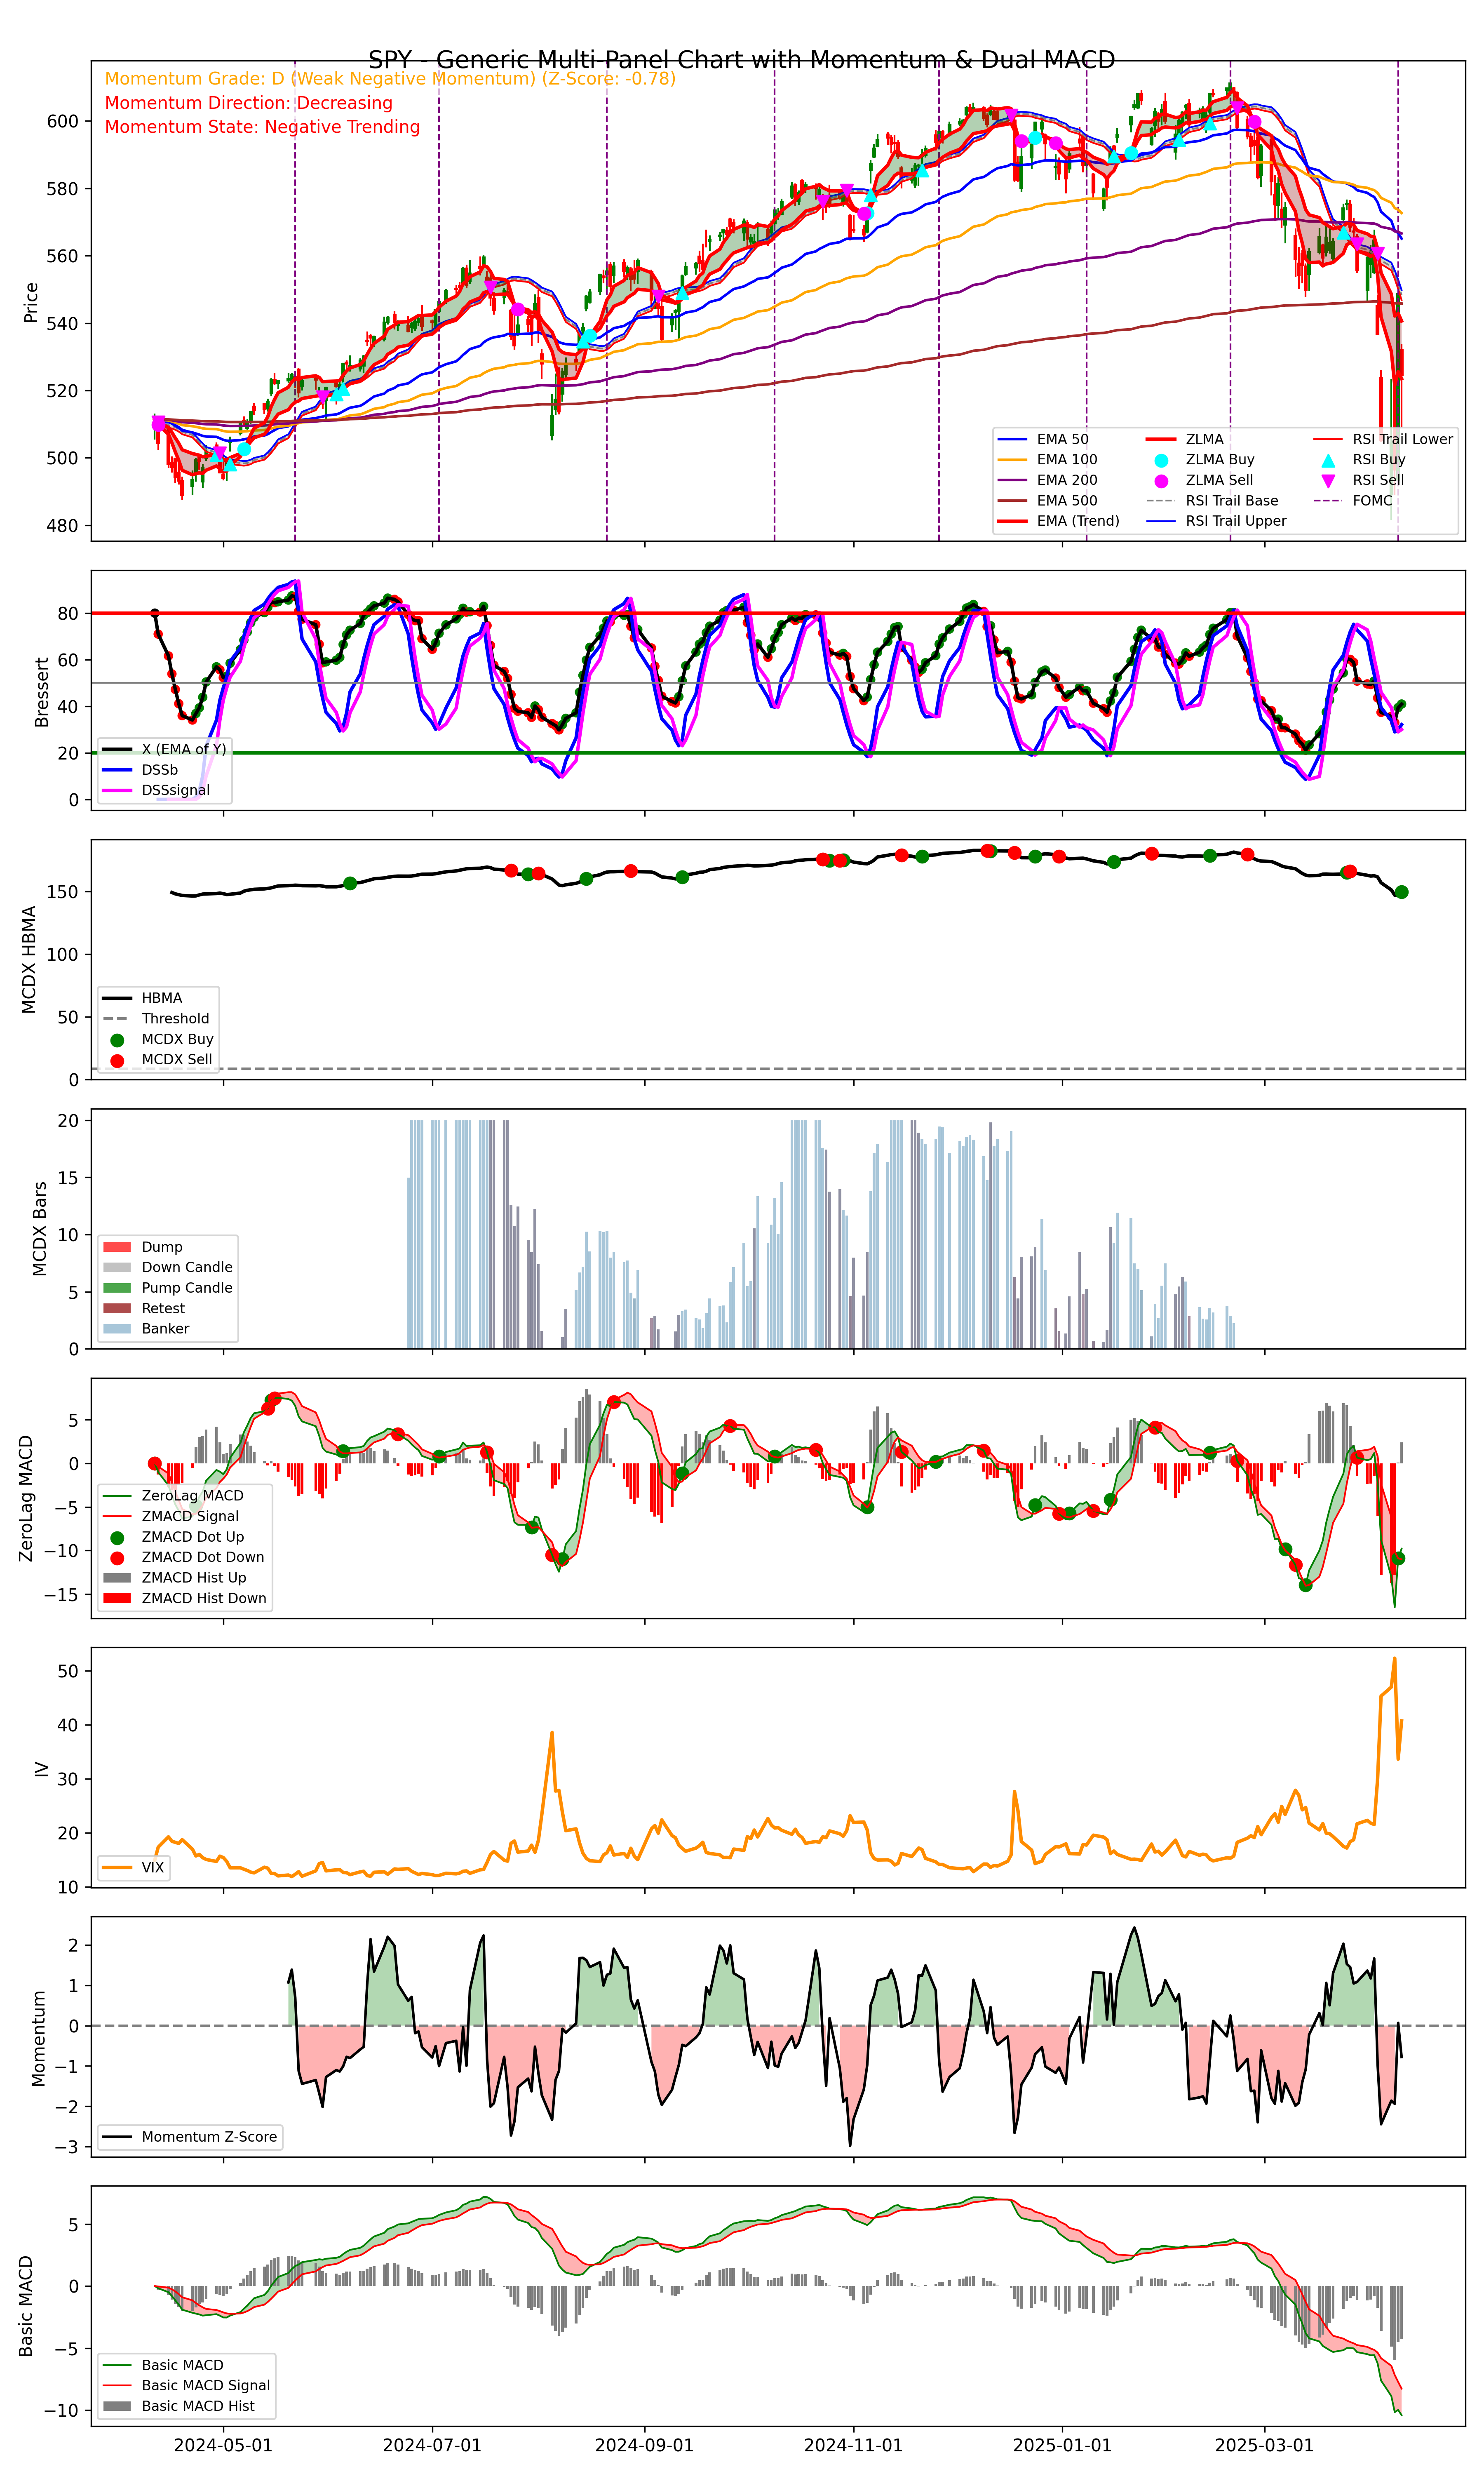

In [27]:
from PIL import Image
from IPython.display import Image as IPyImage, display

img = "chart_output.png"
display(IPyImage(filename=img, width=900))

## Save Stuff (For Seed Searching)
Change the ticker you want to search, also required for initialization.

In [321]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [322]:
# Import required before calling
from datetime import datetime

# Parameters
ticker = "TSLA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

# Call the original function exactly as it exists in your script
save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [323]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open     volume  \
0 2023-06-16  260.540009  263.600006  257.209991  258.920013  167563700   
1 2023-06-20  274.450012  274.750000  261.119995  261.500000  165611200   
2 2023-06-21  259.459991  276.989990  257.779999  275.130005  211797100   
3 2023-06-22  264.609985  265.000000  248.250000  250.770004  166875900   
4 2023-06-23  256.600006  262.450012  252.800003  259.290009  176584100   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  260.540009  260.540009  260.540009  260.540009  ...         1         0   
1  261.085499  260.815454  260.678417  260.595538  ...         0         0   
2  261.021753  260.788613  260.666293  260.591004  ...         1         0   
3  261.162468  260.864284  260.705534  260.607048  ...         1         0   
4  260.983548  260.779843  260.664683  260.591052  ...         1         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0       

#

## Master Trading Env (Start Here)
Halt, run this before continuing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch.nn as nn
from functools import partial

SEED = 102022

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

model.learn(total_timesteps=3000)
print(f"\nTraining Complete")

In [325]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (current_price - env.entry_price) if env.position == 1 else (env.entry_price - current_price) if env.position == -1 else 0.0
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

env.save_trade_log("trade_log_recurrent.csv")
print(f"\nTotal Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Total Reward: -2763.79
Final Balance: 9550.48
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-07-31     Long      255.71     267.43   4.58   
1    2023-08-01  2023-08-03    Short      261.07     259.32   0.67   
2    2023-08-04  2023-08-07    Short      253.86     251.45   0.96   
3    2023-08-08  2023-08-09     Long      249.70     242.19  -3.01   
4    2023-08-10  2023-08-11    Short      245.34     242.65   1.11   
..          ...         ...      ...         ...        ...    ...   
172  2025-03-26  2025-03-27     Long      272.06     273.13   0.39   
173  2025-03-28  2025-04-03    Short      263.55     267.28  -1.40   
174  2025-04-03  2025-04-04     Long      267.28     239.43 -10.42   
175  2025-04-04  2025-04-08    Short      239.43     221.86   7.92   
176  2025-04-08  2025-04-10     Long      221.86     252.40  13.77   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0              4.58          

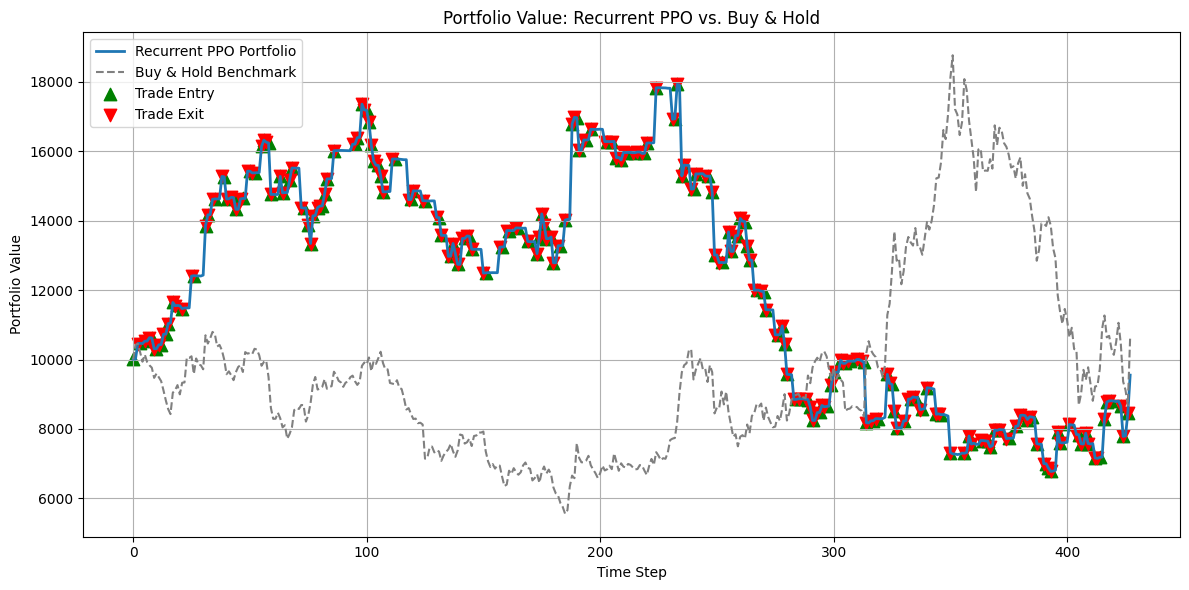

In [326]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

## Start Your Seed Search Below Here ✈

## Fast Fixed Seed Search Above & Below (Find Seeds Here, Deterministic Start on Center Seed)

Fixed seed outputs centered around the main seed

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 49274
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000  # how far above/below to search

# --- Prepare Seed List ---
np.random.seed(CENTER_SEED)

possible_below = np.arange(max(0, CENTER_SEED - SEED_RANGE), CENTER_SEED)
possible_above = np.arange(CENTER_SEED + 1, CENTER_SEED + SEED_RANGE)

n_below = (N_TRIALS - 1) // 2
n_above = N_TRIALS - 1 - n_below

below_seeds = np.random.choice(possible_below, size=n_below, replace=False)
above_seeds = np.random.choice(possible_above, size=n_above, replace=False)

all_seeds = [CENTER_SEED] + list(below_seeds) + list(above_seeds)
np.random.shuffle(all_seeds)

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # Re-init environment and model
    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=0,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.005
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

In [ ]:
# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")


--- Seed Sweep Complete ---
Best Seed: 17394
Best Total Reward: -11765.74
Best Final Balance: 10379.95


## Fixed Seed Search Random (Start Exactly on Center Seed)

Useful once you have a good seed to find better ones

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 112948
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000

# --- Prepare Seed List ---
possible_below = np.arange(max(0, CENTER_SEED - SEED_RANGE), CENTER_SEED)
possible_above = np.arange(CENTER_SEED + 1, CENTER_SEED + SEED_RANGE)

# Number of additional seeds
n_below = (N_TRIALS - 1) // 2
n_above = N_TRIALS - 1 - n_below

# Sample from below and above ranges
np.random.seed(None)
below_seeds = np.random.choice(possible_below, size=n_below, replace=False)
above_seeds = np.random.choice(possible_above, size=n_above, replace=False)

# Combine all seeds, center first
remaining_seeds = list(below_seeds) + list(above_seeds)
np.random.shuffle(remaining_seeds)
all_seeds = [CENTER_SEED] + remaining_seeds

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in all_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=1,
        n_steps=64,
        batch_size=32,
        learning_rate=3e-4,
        gamma=0.99,
        ent_coef=0.005
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

In [ ]:
# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")

## True Random Seed Search (Actually Random)
Nothing works? Find a new seed

In [327]:
import numpy as np
import pandas as pd
import torch
import random
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

# --- Sweep Parameters ---
CENTER_SEED = 83819
N_TRIALS = 11
TOTAL_TIMESTEPS = 3000
SEED_RANGE = 50000

# --- Prepare Random Seeds Around Center ---
low = max(0, CENTER_SEED - SEED_RANGE)
high = CENTER_SEED + SEED_RANGE

np.random.seed(None)
random_seeds = np.random.choice(np.arange(low, high), size=N_TRIALS, replace=False)

# --- Result Tracking ---
results = []
best_model = None
best_score = -np.inf
best_seed = None

# --- Sweep Loop ---
for seed in random_seeds:
    print(f"\n--- Training with seed {seed} ---")

    seed = int(seed)
    set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    env = TradingEnvRL(data.copy(), initial_balance=10000)
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)

    model = RecurrentPPO(
        policy=MlpLstmPolicy,
        env=vec_env,
        seed=seed,
        verbose=0,
        n_steps=64,
        batch_size=32,
        learning_rate=0.01,
        gamma=0.99,
        ent_coef=0.01
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluation
    obs, _ = env.reset()
    state = None
    done = False
    total_reward = 0

    while not done:
        action, state = model.predict(obs, state=state, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward

    final_balance = env.balance
    print(f"Seed {seed}: Reward = {total_reward:.2f}, Final Balance = {final_balance:.2f}")

    # Compute average reward per action
    avg_rewards = {}
    for action, rewards in env.reward_tracker.items():
        label = "Long" if action == 0 else "Short"
        avg = np.mean(rewards) if rewards else 0.0
        avg_rewards[label] = avg
        print(f"Average reward for action {label}: {avg:.4f}")

    results.append((seed, total_reward, final_balance))

    if total_reward > best_score:
        best_score = total_reward
        best_model = model
        best_seed = seed
        model.save("best_recurrent_model.zip")
        print("Best model updated and saved.")

# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")


--- Training with seed 84511 ---
Seed 84511: Reward = -69.15, Final Balance = 12038.12
Average reward for action Long: 0.3914
Average reward for action Short: -0.5380
Best model updated and saved.

--- Training with seed 97974 ---
Seed 97974: Reward = -9070.66, Final Balance = 3522.30
Average reward for action Long: 0.0136
Average reward for action Short: -0.0997

--- Training with seed 64982 ---
Seed 64982: Reward = 7790.18, Final Balance = 19863.73
Average reward for action Long: -0.2441
Average reward for action Short: 0.6258
Best model updated and saved.

--- Training with seed 62977 ---
Seed 62977: Reward = 2570.52, Final Balance = 14840.80
Average reward for action Long: 0.4955
Average reward for action Short: -0.5567

--- Training with seed 111581 ---
Seed 111581: Reward = -6663.71, Final Balance = 5529.87
Average reward for action Long: -0.0897
Average reward for action Short: -0.0450

--- Training with seed 43633 ---
Seed 43633: Reward = -4373.75, Final Balance = 8066.42
Aver

In [328]:
# --- Save Results ---
results_df = pd.DataFrame(results, columns=["Seed", "Reward", "Final Balance"])
results_df.to_csv("seed_sweep_results.csv", index=False)

best_final_balance = results_df.loc[results_df["Seed"] == best_seed, "Final Balance"].values[0]

print("\n--- Seed Sweep Complete ---")
print(f"Best Seed: {best_seed}")
print(f"Best Total Reward: {best_score:.2f}")
print(f"Best Final Balance: {best_final_balance:.2f}")


--- Seed Sweep Complete ---
Best Seed: 109961
Best Total Reward: 10069.41
Best Final Balance: 22325.22


## Stock Test Results 📊

## Last Training on: 4/10/2025
For best replication results try setting the end date to this.

## GOOG

In [500]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [501]:
# Parameters
ticker = "GOOG"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [502]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-16  123.475159  126.102713  123.206435  126.102713  56686800   
1 2023-06-20  123.266144  124.584902  122.250956  122.952634  22698000   
2 2023-06-21  120.688370  122.828236  120.290254  122.654058  22612000   
3 2023-06-22  123.286057  123.350745  119.036182  120.091190  20781900   
4 2023-06-23  122.440063  122.858089  121.285536  121.464688  29542900   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  123.475159  123.475159  123.475159  123.475159  ...         1         0   
1  123.466962  123.471020  123.473079  123.474324  ...         1         0   
2  123.357998  123.415918  123.445370  123.463203  ...         1         0   
3  123.355176  123.413346  123.443785  123.462496  ...         1         0   
4  123.319290  123.394073  123.433798  123.458414  ...         1         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [503]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 88573
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

In [505]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: BUY
Total Reward: 3402.04
Final Balance: 15100.18
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice  PnL%  \
0    2023-07-27  2023-08-02    Short    129.2578   128.0336  0.96   
1    2023-08-03  2023-08-04     Long    128.1630   127.9340 -0.18   
2    2023-08-07  2023-08-09     Long    131.3180   129.5365 -1.36   
3    2023-08-10  2023-08-11     Long    129.5962   129.5564 -0.03   
4    2023-08-14  2023-08-15     Long    131.2085   129.6559 -1.18   
..          ...         ...      ...         ...        ...   ...   
178  2025-03-27  2025-03-28    Short    164.0800   156.0600  5.14   
179  2025-03-28  2025-03-31     Long    156.0600   156.2300  0.11   
180  2025-04-01  2025-04-03    Short    158.8800   152.6300  4.09   
181  2025-04-03  2025-04-07     Long    152.6300   149.2400 -2.22   
182  2025-04-08  2025-04-10    Short    146.5800   155.3700 -5.66   

     CumulativePnL%  CompoundedFactor  CompoundedPnL%  
0 

In [506]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: BUY


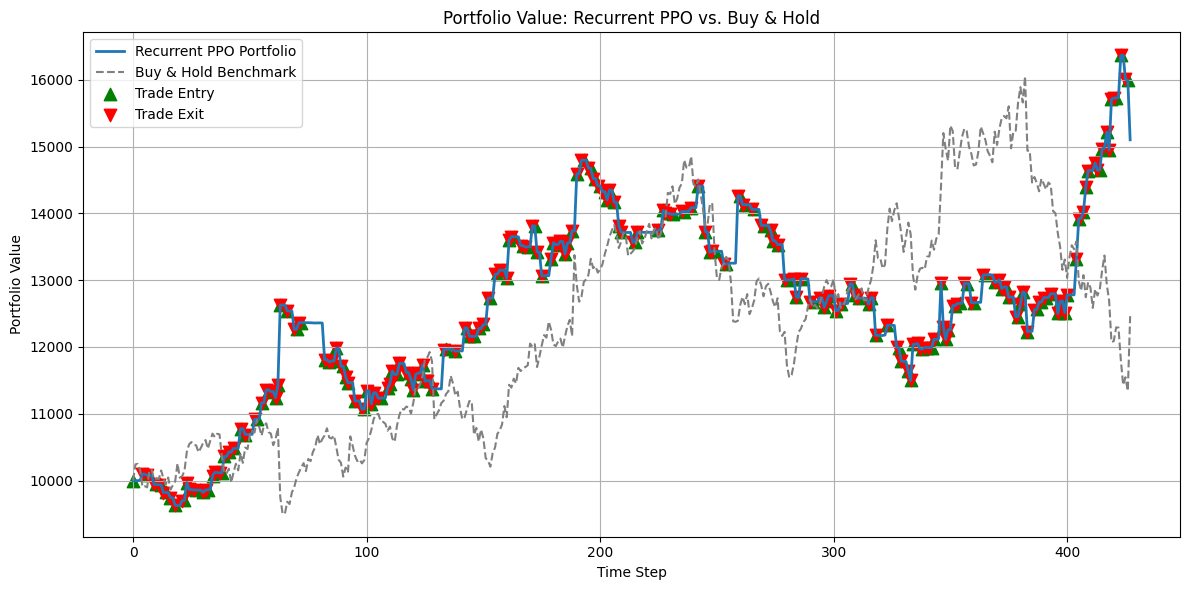

In [507]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

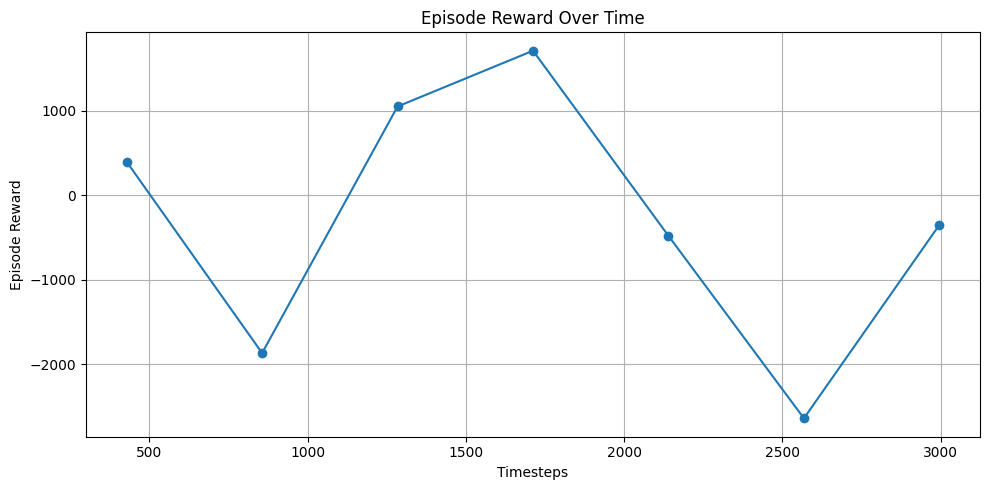

In [508]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

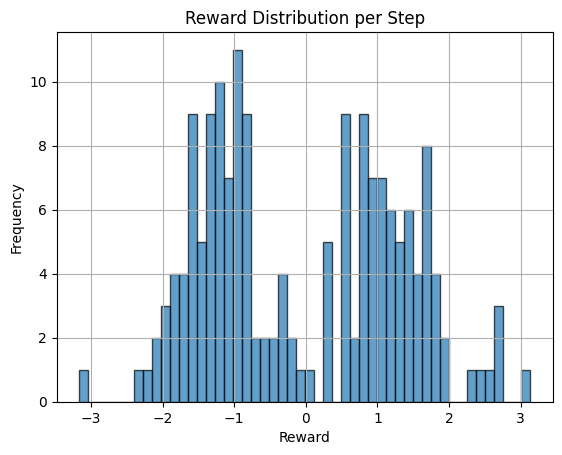

In [509]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

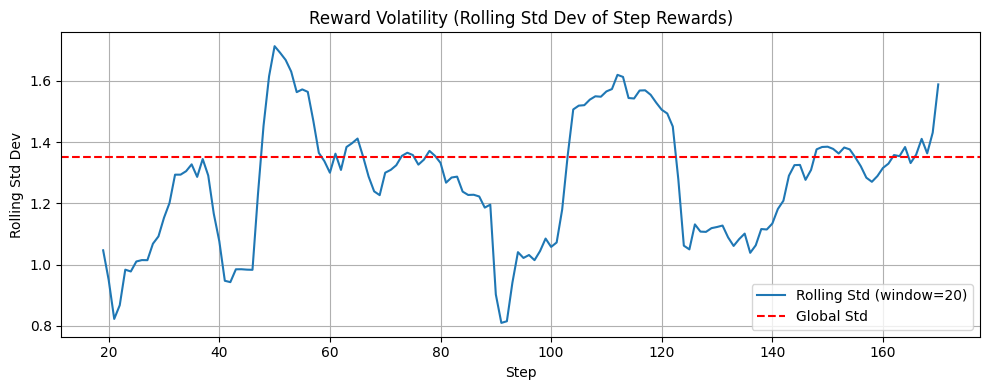

Mean Step Reward: -0.0502
Std Dev of Step Rewards: 1.3521
Variance: 1.8281
Range: 6.2998
Max Rolling Std (20): 1.7136
Min Rolling Std (20): 0.8100


In [510]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 183
Total Transitions: 182
Switches: 142
Switch Rate: 0.7802


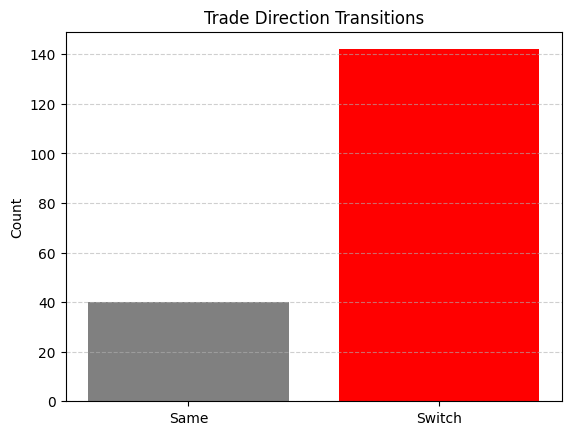

In [511]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

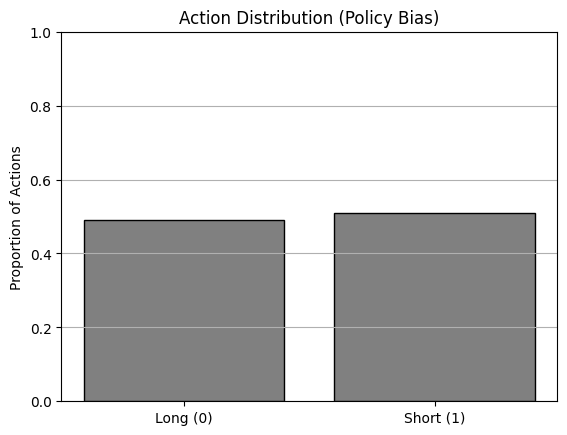

Long (0): Count = 210, Proportion = 49.07%
Short (1): Count = 218, Proportion = 50.93%


In [512]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")

--- Training with seed 88573 ---
Seed 88573: Reward = 3402.05, Final Balance = 15100.19
Average reward for action Long: 0.0169
Average reward for action Short: -0.1150
Best model updated and saved.

--- Training with seed 65343 ---
Seed 65343: Reward = -4979.90, Final Balance = 6706.99
Average reward for action Long: 0.2866
Average reward for action Short: -0.0512

--- Training with seed 44347 ---
Seed 44347: Reward = 3249.87, Final Balance = 14809.75
Average reward for action Long: 0.4132
Average reward for action Short: 0.3986

--- Training with seed 75599 ---
Seed 75599: Reward = 2606.58, Final Balance = 14008.65
Average reward for action Long: 0.4323
Average reward for action Short: 0.2494

--- Training with seed 81024 ---
Seed 81024: Reward = -6856.40, Final Balance = 5296.91
Average reward for action Long: -0.0409
Average reward for action Short: -0.4090

--- Training with seed 78092 ---
Seed 78092: Reward = 3352.69, Final Balance = 15044.88
Average reward for action Long: 0.7192
Average reward for action Short: 0.1192

--- Training with seed 72471 ---
Seed 72471: Reward = 732.29, Final Balance = 12317.76
Average reward for action Long: 0.1188
Average reward for action Short: 0.1239

--- Training with seed 112103 ---
Seed 112103: Reward = -6388.21, Final Balance = 5675.00
Average reward for action Long: -0.2011
Average reward for action Short: -0.3009

--- Training with seed 57977 ---
Seed 57977: Reward = -4607.66, Final Balance = 7337.97
Average reward for action Long: -0.0022
Average reward for action Short: 0.1151

--- Training with seed 38635 ---
Seed 38635: Reward = -3719.01, Final Balance = 8201.49
Average reward for action Long: 0.4568
Average reward for action Short: -0.0798

--- Training with seed 90866 ---
Seed 90866: Reward = -2050.35, Final Balance = 9696.36
Average reward for action Long: 0.1171
Average reward for action Short: 0.0206

--- Seed Sweep Complete ---
Best Seed: 88573
Best Total Reward: 3402.05
Best Final Balance: 15100.19

In [513]:
model.save("GOOG_best_model")

## AMZN

In [514]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [515]:
# Parameters
ticker = "AMZN"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [516]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-16  125.489998  127.900002  125.300003  127.709999  84188100   
1 2023-06-20  125.779999  127.250000  124.500000  124.970001  56930100   
2 2023-06-21  124.830002  126.730003  123.849998  125.639999  52137700   
3 2023-06-22  130.149994  130.330002  125.139999  125.309998  90354600   
4 2023-06-23  129.330002  130.839996  128.279999  129.110001  71855200   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  125.489998  125.489998  125.489998  125.489998  ...         1         0   
1  125.501370  125.495740  125.492883  125.491156  ...         1         0   
2  125.475042  125.482558  125.486288  125.488516  ...         1         0   
3  125.658374  125.574982  125.532693  125.507125  ...         0         0   
4  125.802359  125.649339  125.570477  125.522386  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [517]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 78768
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

In [519]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: BUY
Total Reward: 3329.88
Final Balance: 15003.76
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-07-28     Long      128.25     132.21   3.09   
1    2023-07-31  2023-08-03    Short      133.68     128.91   3.70   
2    2023-08-04  2023-08-09    Short      139.57     137.85   1.25   
3    2023-08-10  2023-08-11    Short      138.56     138.41   0.11   
4    2023-08-14  2023-08-15    Short      140.57     137.67   2.11   
..          ...         ...      ...         ...        ...    ...   
169  2025-03-28  2025-03-31    Short      192.72     190.26   1.29   
170  2025-03-31  2025-04-01     Long      190.26     192.17   1.00   
171  2025-04-02  2025-04-08    Short      196.01     170.66  14.85   
172  2025-04-08  2025-04-09     Long      170.66     191.10  11.98   
173  2025-04-09  2025-04-10    Short      191.10     181.22   5.45   

     CumulativePnL%  CompoundedFactor  Compoun

In [520]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: BUY


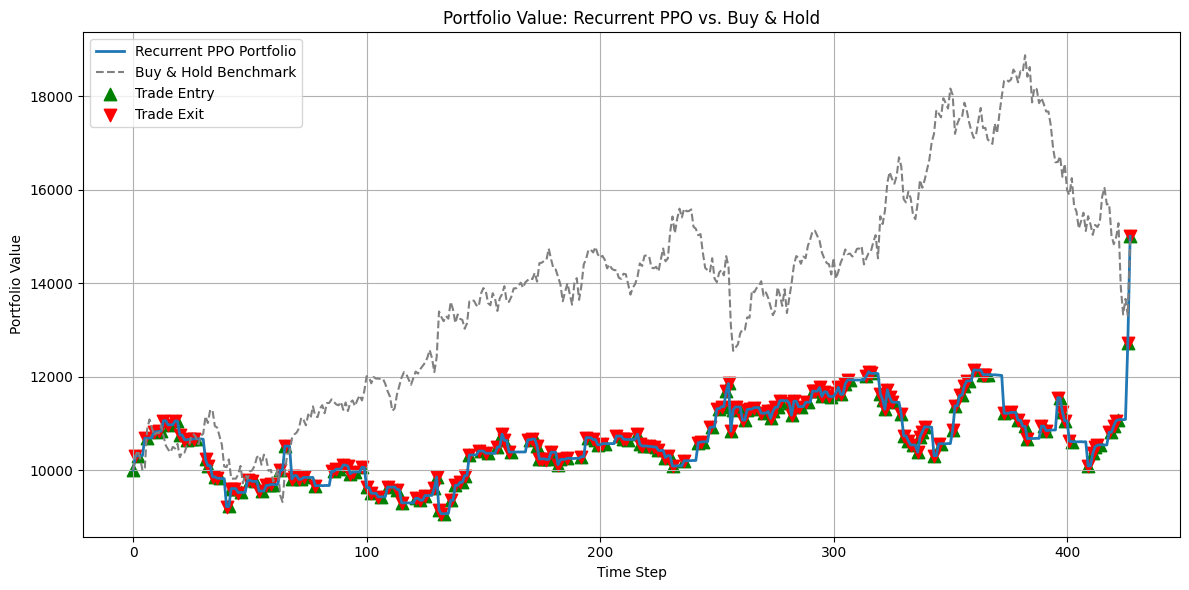

In [521]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

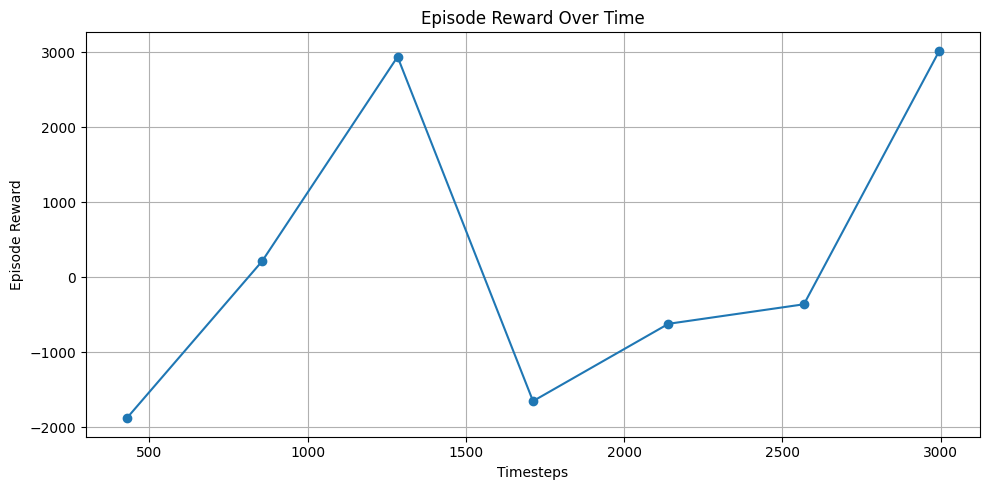

In [522]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

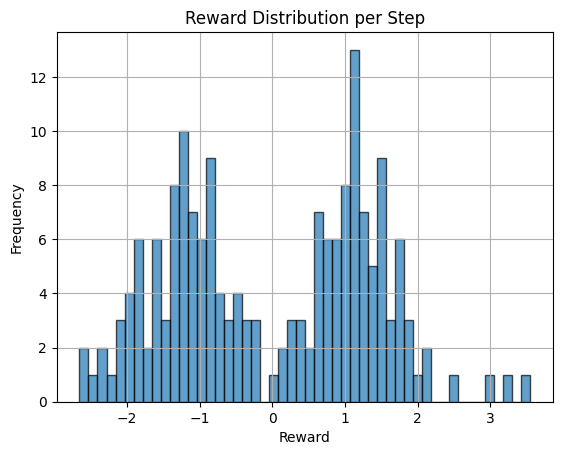

In [523]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

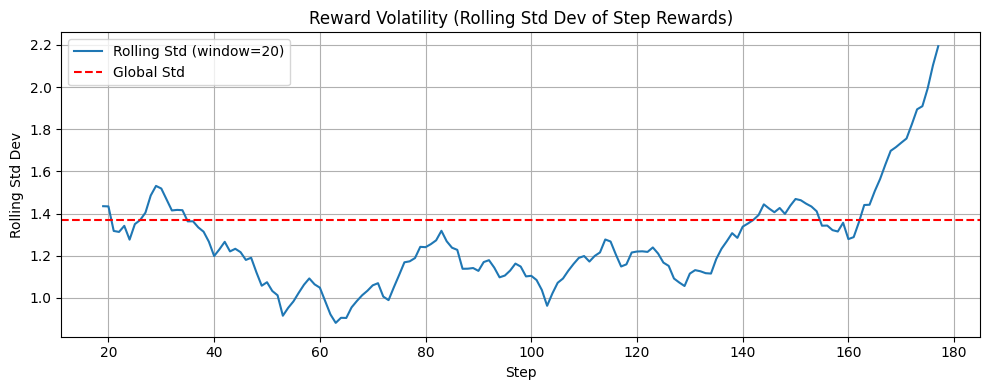

Mean Step Reward: -0.0036
Std Dev of Step Rewards: 1.3703
Variance: 1.8777
Range: 6.2073
Max Rolling Std (20): 2.1944
Min Rolling Std (20): 0.8812


In [524]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 174
Total Transitions: 173
Switches: 129
Switch Rate: 0.7457


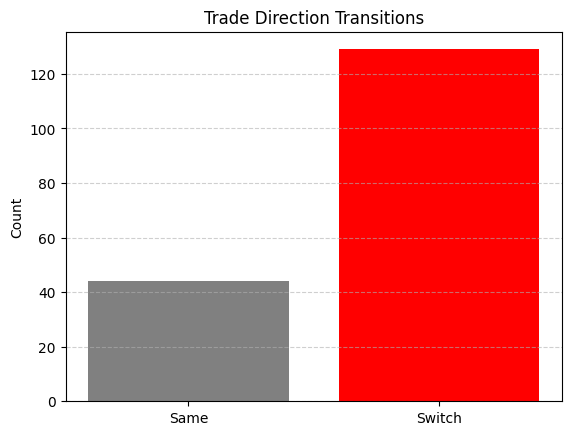

In [525]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

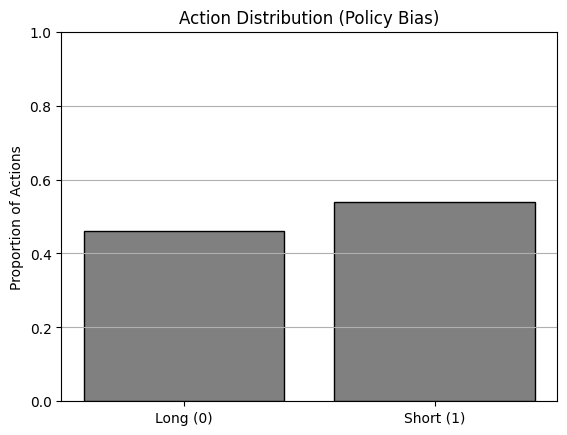

Long (0): Count = 197, Proportion = 46.03%
Short (1): Count = 231, Proportion = 53.97%


In [526]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")




--- Training with seed 58630 ---
Seed 58630: Reward = 1182.75, Final Balance = 12750.29
Average reward for action Long: 0.3288
Average reward for action Short: -0.4190
Best model updated and saved.

--- Training with seed 91454 ---
Seed 91454: Reward = -3917.27, Final Balance = 8096.02
Average reward for action Long: 0.0848
Average reward for action Short: -0.3334

--- Training with seed 81001 ---
Seed 81001: Reward = -4347.41, Final Balance = 7382.52
Average reward for action Long: -0.5212
Average reward for action Short: -0.3672

--- Training with seed 40163 ---
Seed 40163: Reward = 1815.62, Final Balance = 13615.02
Average reward for action Long: 0.2187
Average reward for action Short: -0.2444
Best model updated and saved.

--- Training with seed 78768 ---
Seed 78768: Reward = 5456.93, Final Balance = 17079.26
Average reward for action Long: 0.1406
Average reward for action Short: -0.0176
Best model updated and saved.

--- Training with seed 64909 ---
Seed 64909: Reward = 2967.96, Final Balance = 14889.38
Average reward for action Long: 0.1946
Average reward for action Short: 0.0206

--- Training with seed 120070 ---
Seed 120070: Reward = -4524.22, Final Balance = 7404.34
Average reward for action Long: -0.1343
Average reward for action Short: -0.2350

--- Training with seed 97257 ---
Seed 97257: Reward = -2579.63, Final Balance = 9205.13
Average reward for action Long: 0.0203
Average reward for action Short: -0.3204

--- Training with seed 123783 ---
Seed 123783: Reward = 1518.37, Final Balance = 13395.80
Average reward for action Long: 0.0246
Average reward for action Short: -0.0679

--- Training with seed 120497 ---
Seed 120497: Reward = -2572.49, Final Balance = 9149.12
Average reward for action Long: 0.1572
Average reward for action Short: -0.1886

--- Training with seed 107358 ---
Seed 107358: Reward = -2230.98, Final Balance = 9478.17
Average reward for action Long: -0.1151
Average reward for action Short: -0.1609

--- Seed Sweep Complete ---
Best Seed: 78768
Best Total Reward: 5456.93
Best Final Balance: 17079.26

In [527]:
model.save("AMZN_best_model")

## AAPL

In [528]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [529]:
# Parameters
ticker = "AAPL"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [530]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open     volume  \
0 2023-06-16  183.326981  185.379156  182.682586  185.121386  101235600   
1 2023-06-20  183.416199  184.496820  182.821377  182.821377   49799100   
2 2023-06-21  182.375275  183.812781  181.017066  183.307164   49515700   
3 2023-06-22  185.389069  185.438641  182.087753  182.157158   51245300   
4 2023-06-23  185.071808  185.944232  183.416196  183.951553   53079300   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  183.326981  183.326981  183.326981  183.326981  ...         1         0   
1  183.330479  183.328747  183.327868  183.327337  ...         1         0   
2  183.293020  183.309867  183.318390  183.323536  ...         1         0   
3  183.375218  183.351039  183.338994  183.331782  ...         1         0   
4  183.441751  183.385114  183.356235  183.338728  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0       

In [531]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 128030
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 212 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 128         |
| train/                  |             |
|    approx_kl            | 0.022984039 |
|    clip_fraction        | 0.483       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.667      |
|    explained_variance   | 0.000254    |
|    learning_rate        | 0.01        |
|    loss                 | 8.64e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 7.3e+04     |
-----------------------------------------
-----------------------

In [533]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: BUY
Total Reward: 4716.27
Final Balance: 16302.66
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-07-28     Long    191.5555   194.1430   1.35   
1    2023-07-31  2023-08-01    Short    194.7576   193.9249   0.43   
2    2023-08-02  2023-08-08     Long    190.9210   178.2511  -6.64   
3    2023-08-09  2023-08-11    Short    176.6550   176.4964   0.09   
4    2023-08-14  2023-08-15    Short    178.1543   176.1589   1.13   
..          ...         ...      ...         ...        ...    ...   
171  2025-03-27  2025-04-03    Short    223.8500   203.1900  10.17   
172  2025-04-03  2025-04-07     Long    203.1900   181.4600 -10.69   
173  2025-04-07  2025-04-08    Short    181.4600   172.4200   5.24   
174  2025-04-08  2025-04-09     Long    172.4200   198.8500  15.33   
175  2025-04-09  2025-04-10    Short    198.8500   190.4200   4.43   

     CumulativePnL%  CompoundedFactor  Compoun

In [534]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: BUY


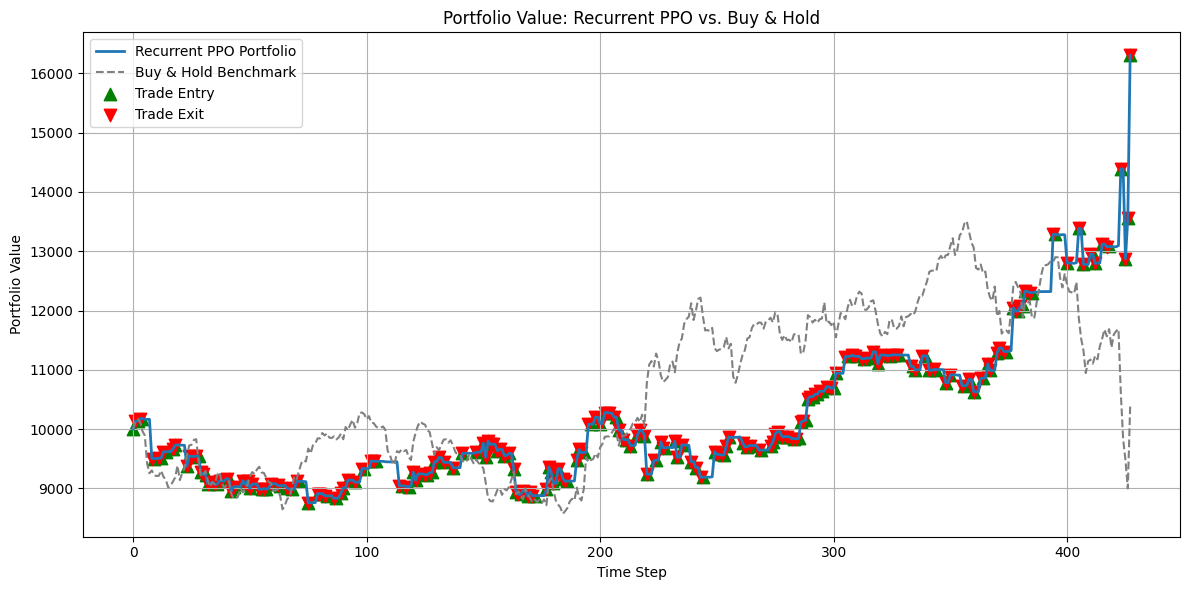

In [535]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

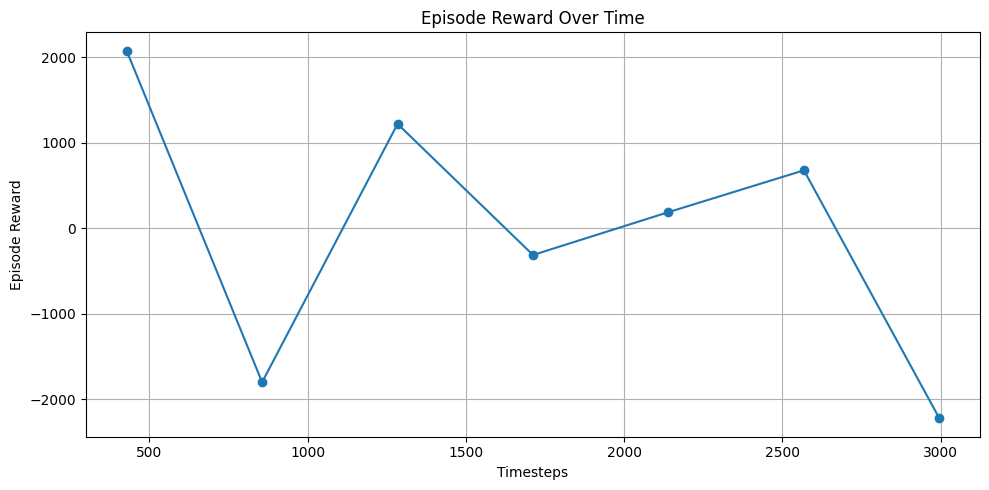

In [536]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

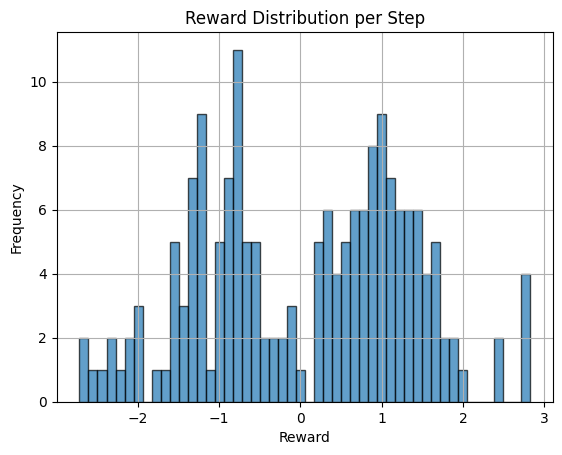

In [537]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

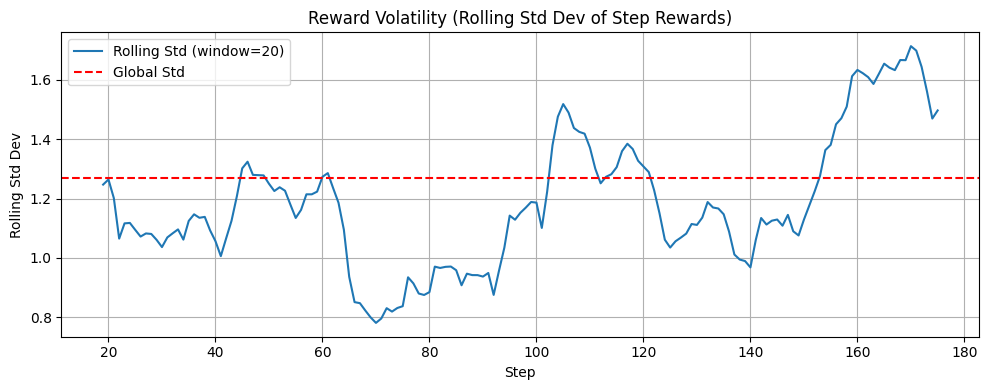

Mean Step Reward: 0.0649
Std Dev of Step Rewards: 1.2698
Variance: 1.6125
Range: 5.5483
Max Rolling Std (20): 1.7133
Min Rolling Std (20): 0.7813


In [538]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 176
Total Transitions: 175
Switches: 137
Switch Rate: 0.7829


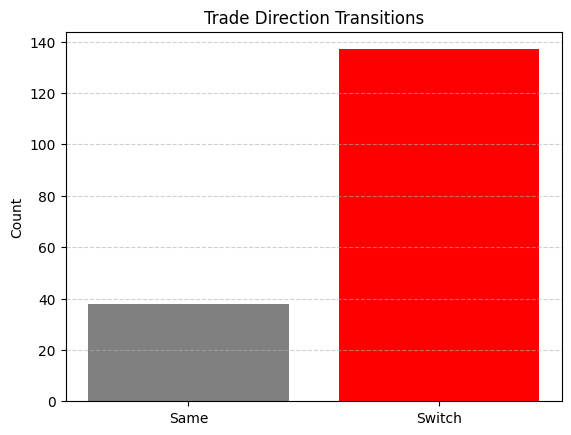

In [539]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

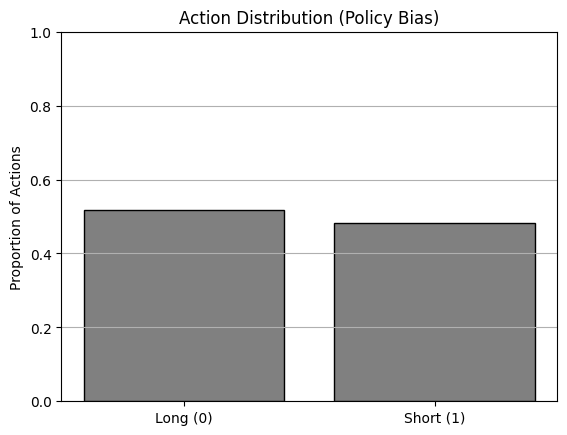

Long (0): Count = 222, Proportion = 51.87%
Short (1): Count = 206, Proportion = 48.13%


In [540]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")

--- Training with seed 71719 ---
Seed 71719: Reward = -164.56, Final Balance = 11574.93
Average reward for action Long: -0.0565
Average reward for action Short: 0.1578
Best model updated and saved.

--- Training with seed 34867 ---
Seed 34867: Reward = -4979.62, Final Balance = 6732.89
Average reward for action Long: 0.0093
Average reward for action Short: 0.0643

--- Training with seed 57617 ---
Seed 57617: Reward = -2588.05, Final Balance = 9053.52
Average reward for action Long: 0.2192
Average reward for action Short: -0.2105

--- Training with seed 122493 ---
Seed 122493: Reward = 331.47, Final Balance = 11925.18
Average reward for action Long: 0.2236
Average reward for action Short: -0.3920
Best model updated and saved.

--- Training with seed 47139 ---
Seed 47139: Reward = 1809.22, Final Balance = 13726.43
Average reward for action Long: 0.0164
Average reward for action Short: -0.1107
Best model updated and saved.

--- Training with seed 128030 ---
Seed 128030: Reward = 4716.23, Final Balance = 16302.62
Average reward for action Long: 0.1187
Average reward for action Short: 0.0004
Best model updated and saved.

--- Training with seed 45301 ---
Seed 45301: Reward = 219.28, Final Balance = 11712.43
Average reward for action Long: 0.2243
Average reward for action Short: 0.0845

--- Training with seed 58376 ---
Seed 58376: Reward = -4153.13, Final Balance = 7403.73
Average reward for action Long: 0.0082
Average reward for action Short: -0.2599

--- Training with seed 119695 ---
Seed 119695: Reward = 4637.83, Final Balance = 16022.76
Average reward for action Long: 0.4593
Average reward for action Short: 0.1460

--- Training with seed 37431 ---
Seed 37431: Reward = -1709.18, Final Balance = 9801.24
Average reward for action Long: 0.1996
Average reward for action Short: -0.0553

--- Training with seed 107833 ---
Seed 107833: Reward = -1798.95, Final Balance = 9891.31
Average reward for action Long: 0.0503
Average reward for action Short: 0.0821

--- Seed Sweep Complete ---
Best Seed: 128030
Best Total Reward: 4716.23
Best Final Balance: 16302.62

In [541]:
model.save("AAPL_best_model")

## META

In [542]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [543]:
# Parameters
ticker = "META"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [544]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-16  279.681885  286.499759  278.815971  283.414294  43102500   
1 2023-06-20  282.996216  283.464012  274.924274  277.422509  20701600   
2 2023-06-21  280.318848  282.667762  277.054205  282.199966  20556200   
3 2023-06-22  283.543640  283.921862  276.486903  277.770830  17563100   
4 2023-06-23  287.375610  288.311203  277.641488  280.189477  50988400   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  279.681885  279.681885  279.681885  279.681885  ...         1         0   
1  279.811859  279.747515  279.714863  279.695116  ...         1         0   
2  279.831740  279.758829  279.720873  279.697606  ...         1         0   
3  279.977305  279.833775  279.758910  279.712959  ...         1         0   
4  280.267435  279.983119  279.834699  279.743548  ...         0         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [545]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 73352
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

Using cuda device
----------------------------
| time/              |     |
|    fps             | 268 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 128         |
| train/                  |             |
|    approx_kl            | 0.026080996 |
|    clip_fraction        | 0.317       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.677      |
|    explained_variance   | 8.03e-05    |
|    learning_rate        | 0.01        |
|    loss                 | 4.37e+04    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00713    |
|    value_loss           | 1.18e+05    |
-----------------------------------------
-----------------------

In [547]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: SELL
Total Reward: 11332.70
Final Balance: 22961.60
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-07-28    Short    310.2478   323.9532  -4.23   
1    2023-07-31  2023-08-03    Short    317.1055   311.7209   1.73   
2    2023-08-04  2023-08-07    Short    309.2724   315.0750  -1.84   
3    2023-08-08  2023-08-09    Short    311.1735   303.7783   2.43   
4    2023-08-10  2023-08-16     Long    304.3058   292.9095  -3.75   
..          ...         ...      ...         ...        ...    ...   
172  2025-03-18  2025-03-19    Short    582.3600   584.0600  -0.29   
173  2025-03-20  2025-03-24     Long    586.0000   618.8500   5.61   
174  2025-03-24  2025-03-31    Short    618.8500   576.3600   7.37   
175  2025-04-01  2025-04-07    Short    586.0000   516.2500  13.51   
176  2025-04-07  2025-04-10     Long    516.2500   546.2900   5.82   

     CumulativePnL%  CompoundedFactor  Compo

In [548]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: SELL


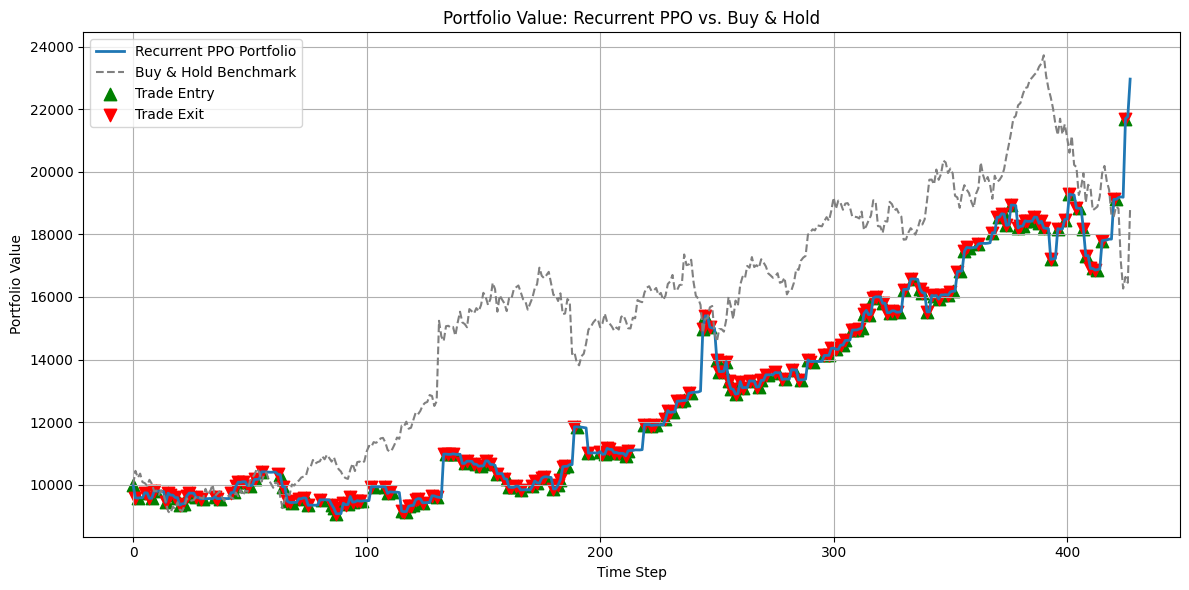

In [549]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

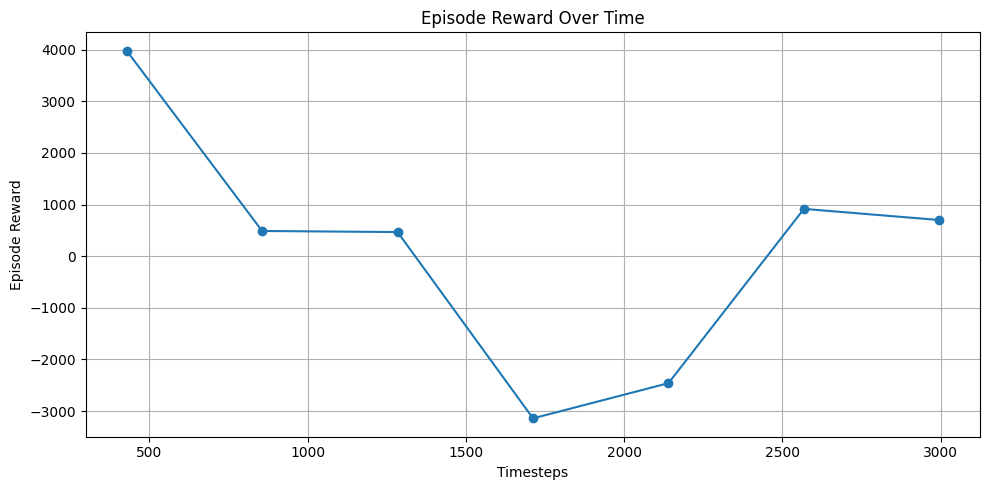

In [550]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

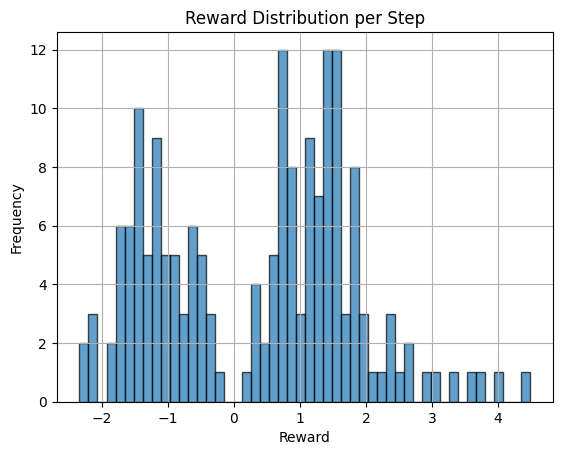

In [551]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

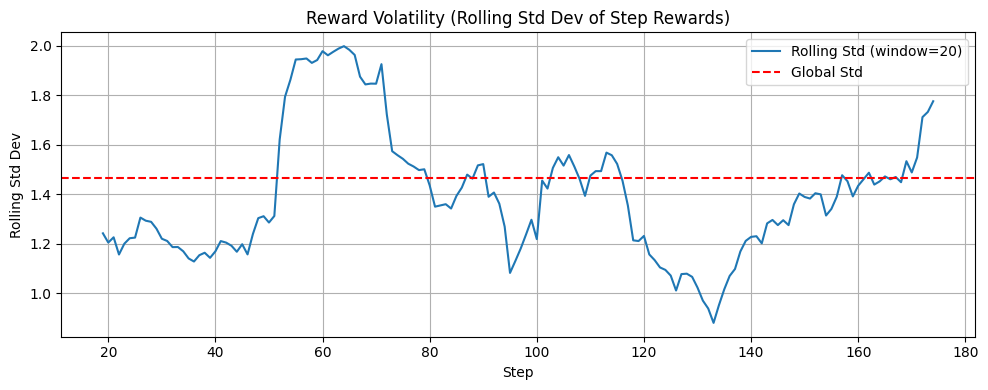

Mean Step Reward: 0.3679
Std Dev of Step Rewards: 1.4658
Variance: 2.1486
Range: 6.8229
Max Rolling Std (20): 1.9977
Min Rolling Std (20): 0.8796


In [552]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 177
Total Transitions: 176
Switches: 135
Switch Rate: 0.7670


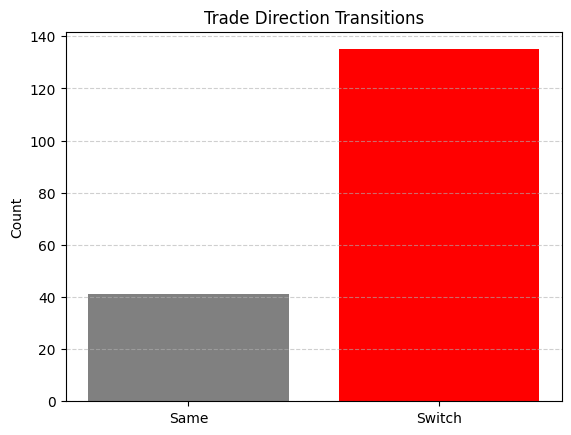

In [553]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

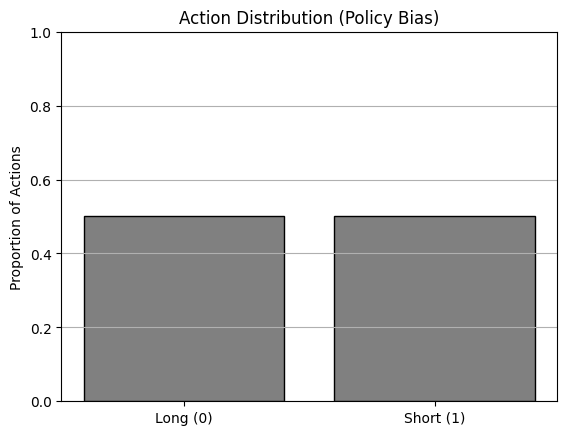

Long (0): Count = 214, Proportion = 50.00%
Short (1): Count = 214, Proportion = 50.00%


In [554]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")

--- Training with seed 49863 ---
Seed 49863: Reward = -1790.80, Final Balance = 10230.76
Average reward for action Long: 0.4532
Average reward for action Short: -0.2896
Best model updated and saved.

--- Training with seed 73352 ---
Seed 73352: Reward = 11332.71, Final Balance = 22961.61
Average reward for action Long: 0.6296
Average reward for action Short: 0.1092
Best model updated and saved.

--- Training with seed 114146 ---
Seed 114146: Reward = 1341.21, Final Balance = 13066.03
Average reward for action Long: 0.2273
Average reward for action Short: 0.0563

--- Training with seed 37234 ---
Seed 37234: Reward = 4619.64, Final Balance = 16387.20
Average reward for action Long: 0.2038
Average reward for action Short: 0.3025

--- Training with seed 52682 ---
Seed 52682: Reward = 2486.83, Final Balance = 14374.79
Average reward for action Long: -0.3329
Average reward for action Short: -0.1697

--- Training with seed 44348 ---
Seed 44348: Reward = -5730.73, Final Balance = 6355.58
Average reward for action Long: 0.1135
Average reward for action Short: -0.8020

--- Training with seed 70193 ---
Seed 70193: Reward = -8681.13, Final Balance = 3719.05
Average reward for action Long: -0.1616
Average reward for action Short: -0.5804

--- Training with seed 88635 ---
Seed 88635: Reward = 5027.80, Final Balance = 16530.86
Average reward for action Long: 0.3168
Average reward for action Short: -0.1560

--- Training with seed 78409 ---
Seed 78409: Reward = -4271.84, Final Balance = 7909.80
Average reward for action Long: -0.2609
Average reward for action Short: -0.0922

--- Training with seed 85452 ---
Seed 85452: Reward = 10804.68, Final Balance = 22520.33
Average reward for action Long: 0.2810
Average reward for action Short: -0.1286

--- Training with seed 116433 ---
Seed 116433: Reward = -5220.17, Final Balance = 6784.07
Average reward for action Long: 0.3066
Average reward for action Short: -0.4070

--- Seed Sweep Complete ---
Best Seed: 73352
Best Total Reward: 11332.71
Best Final Balance: 22961.61

In [555]:
model.save("META_best_model")

## MSFT

In [556]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [557]:
# Parameters
ticker = "MSFT"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [558]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open    volume  \
0 2023-06-16  337.707245  346.723835  337.332402  346.575867  46533600   
1 2023-06-20  333.485016  337.460594  331.324587  334.728011  26375400   
2 2023-06-21  329.055695  333.169397  327.585825  331.827747  25117800   
3 2023-06-22  335.122620  335.527087  328.838644  329.608109  23556800   
4 2023-06-23  330.495972  333.396273  328.947195  329.844881  23084700   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  337.707245  337.707245  337.707245  337.707245  ...         1         0   
1  337.541667  337.623636  337.665233  337.690390  ...         1         0   
2  337.208884  337.453974  337.579566  337.655920  ...         1         0   
3  337.127070  337.407809  337.555118  337.645807  ...         1         0   
4  336.867027  337.270941  337.484878  337.617265  ...         1         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1  

In [559]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 96147
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

In [561]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: SELL
Total Reward: 7669.29
Final Balance: 19214.39
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-08-01    Short    326.2540   331.7982  -1.67   
1    2023-08-02  2023-08-04    Short    323.0775   323.3537  -0.09   
2    2023-08-07  2023-08-08     Long    325.6522   321.6471  -1.23   
3    2023-08-09  2023-08-11     Long    317.8787   316.6751  -0.38   
4    2023-08-14  2023-08-15    Short    319.6642   317.5137   0.68   
..          ...         ...      ...         ...        ...    ...   
173  2025-03-21  2025-03-24    Short    391.2600   393.0800  -0.46   
174  2025-03-25  2025-04-02    Short    395.1600   382.1400   3.41   
175  2025-04-03  2025-04-08    Short    373.1100   354.5600   5.23   
176  2025-04-08  2025-04-09     Long    354.5600   390.4900  10.13   
177  2025-04-09  2025-04-10    Short    390.4900   381.3500   2.40   

     CumulativePnL%  CompoundedFactor  Compou

In [562]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: SELL


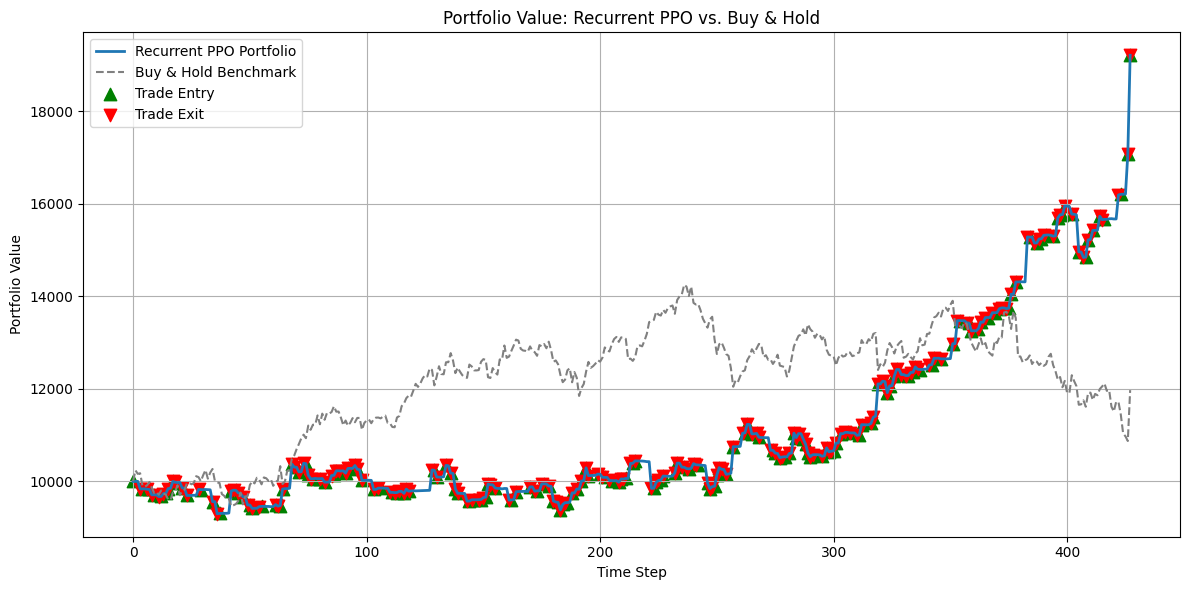

In [563]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

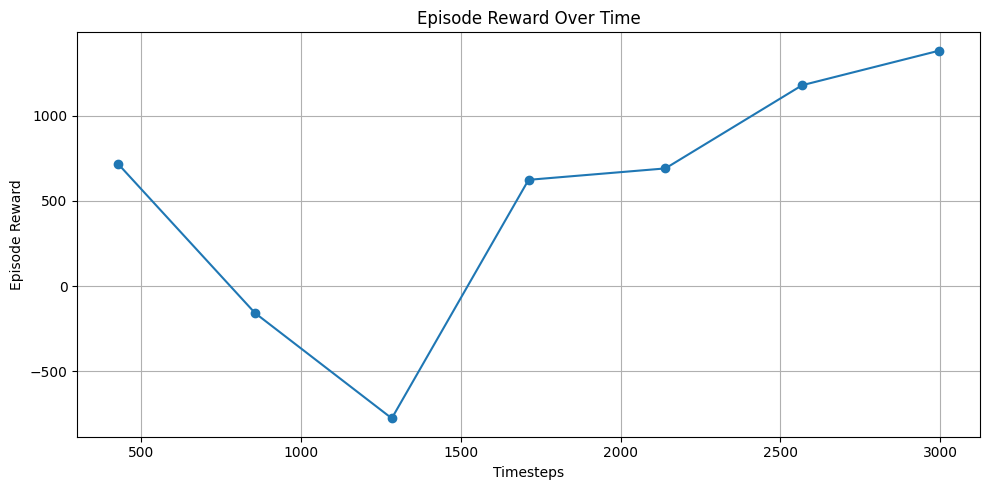

In [564]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

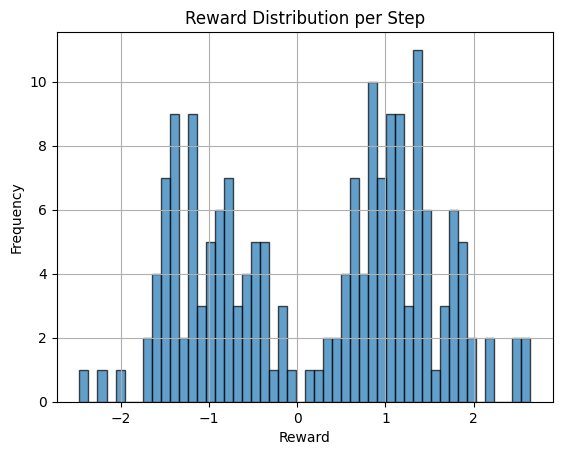

In [565]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

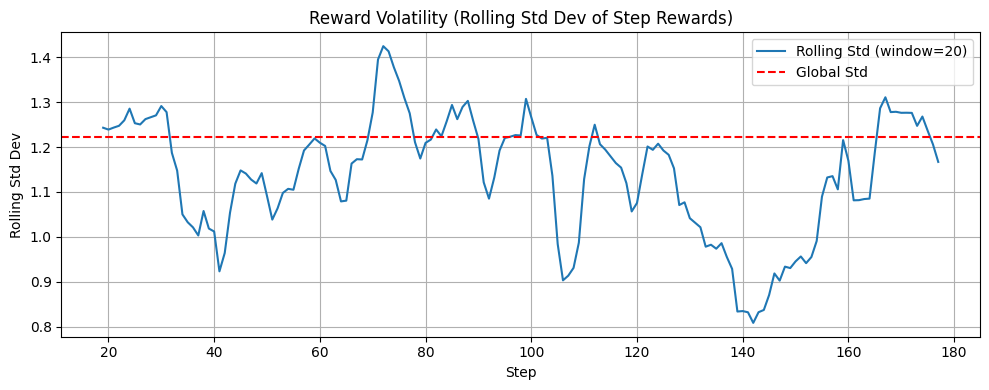

Mean Step Reward: 0.2126
Std Dev of Step Rewards: 1.2217
Variance: 1.4926
Range: 5.1155
Max Rolling Std (20): 1.4249
Min Rolling Std (20): 0.8083


In [566]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 178
Total Transitions: 177
Switches: 146
Switch Rate: 0.8249


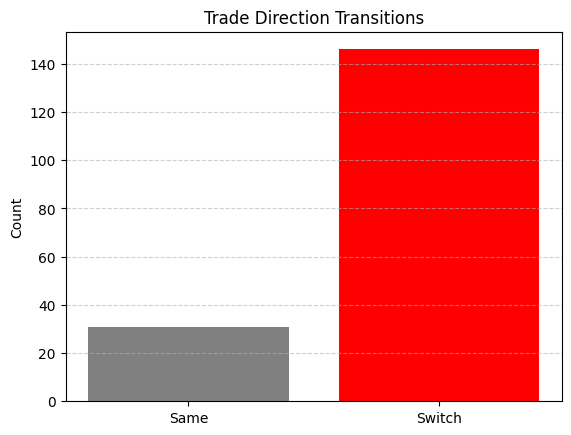

In [567]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

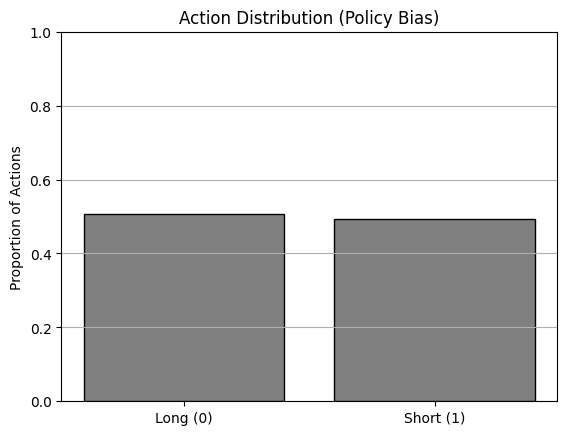

Long (0): Count = 217, Proportion = 50.70%
Short (1): Count = 211, Proportion = 49.30%


In [568]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")

--- Training with seed 50347 ---
Seed 50347: Reward = 3326.04, Final Balance = 14929.36
Average reward for action Long: 0.2001
Average reward for action Short: -0.1709
Best model updated and saved.

--- Training with seed 115278 ---
Seed 115278: Reward = 259.69, Final Balance = 11949.41
Average reward for action Long: 0.1923
Average reward for action Short: -0.1650

--- Training with seed 131667 ---
Seed 131667: Reward = 2915.38, Final Balance = 14837.79
Average reward for action Long: 0.1218
Average reward for action Short: -0.4758

--- Training with seed 127306 ---
Seed 127306: Reward = 3358.08, Final Balance = 15112.39
Average reward for action Long: 0.4093
Average reward for action Short: -0.2912
Best model updated and saved.

--- Training with seed 76487 ---
Seed 76487: Reward = 3018.97, Final Balance = 14742.02
Average reward for action Long: 0.2445
Average reward for action Short: -0.6318

--- Training with seed 92365 ---
Seed 92365: Reward = -4420.60, Final Balance = 7503.18
Average reward for action Long: -0.0679
Average reward for action Short: -0.4151

--- Training with seed 58262 ---
Seed 58262: Reward = -1632.51, Final Balance = 10381.70
Average reward for action Long: 0.1275
Average reward for action Short: -0.5116

--- Training with seed 76099 ---
Seed 76099: Reward = 228.53, Final Balance = 12044.49
Average reward for action Long: 0.3265
Average reward for action Short: 0.0292

--- Training with seed 96147 ---
Seed 96147: Reward = 8151.74, Final Balance = 19766.26
Average reward for action Long: 0.5826
Average reward for action Short: 0.1154
Best model updated and saved.

--- Training with seed 107905 ---
Seed 107905: Reward = 3193.40, Final Balance = 14883.34
Average reward for action Long: 0.8358
Average reward for action Short: -0.4058

--- Training with seed 113756 ---
Seed 113756: Reward = -4101.27, Final Balance = 7844.85
Average reward for action Long: 0.0314
Average reward for action Short: -0.2609

--- Seed Sweep Complete ---
Best Seed: 96147
Best Total Reward: 8151.74
Best Final Balance: 19766.26

In [569]:
model.save("MSFT_best_model")

## NVDA

In [486]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [487]:
# Parameters
ticker = "NVDA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [488]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date      close       high        low       open     volume  \
0 2023-06-16  42.668709  43.697147  42.637724  43.426295  655709000   
1 2023-06-20  43.784096  43.965999  42.650716  42.974540  451153000   
2 2023-06-21  43.021511  43.591204  42.057041  43.477264  551603000   
3 2023-06-22  43.001526  43.402304  42.210957  42.229944  417737000   
4 2023-06-23  42.185974  42.785645  41.992080  42.440836  358140000   

      EMA_50    EMA_100    EMA_200    EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  42.668709  42.668709  42.668709  42.668709  ...         1         0   
1  42.712449  42.690796  42.679807  42.673161  ...         0         0   
2  42.724570  42.697344  42.683207  42.674552  ...         0         0   
3  42.735431  42.703368  42.686375  42.675857  ...         0         0   
4  42.713883  42.693122  42.681395  42.673902  ...         1         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0          1        0         1                 0       

In [489]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 34500
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

In [491]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: BUY
Total Reward: 26026.52
Final Balance: 37747.27
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-07-28     Long     45.8750    46.7245   1.85   
1    2023-07-31  2023-08-01    Short     46.7035    46.4816   0.48   
2    2023-08-02  2023-08-07    Short     44.2449    45.3922  -2.53   
3    2023-08-08  2023-08-09    Short     44.6396    42.5308   4.96   
4    2023-08-10  2023-08-11     Long     42.3649    40.8327  -3.62   
..          ...         ...      ...         ...        ...    ...   
170  2025-03-24  2025-03-25     Long    121.4100   120.6900  -0.59   
171  2025-03-26  2025-04-04    Short    113.7600    94.3100  20.62   
172  2025-04-04  2025-04-07     Long     94.3100    97.6400   3.53   
173  2025-04-07  2025-04-08    Short     97.6400    96.3000   1.39   
174  2025-04-09  2025-04-10     Long    114.3300   107.5700  -5.91   

     CumulativePnL%  CompoundedFactor  Compou

In [492]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: BUY


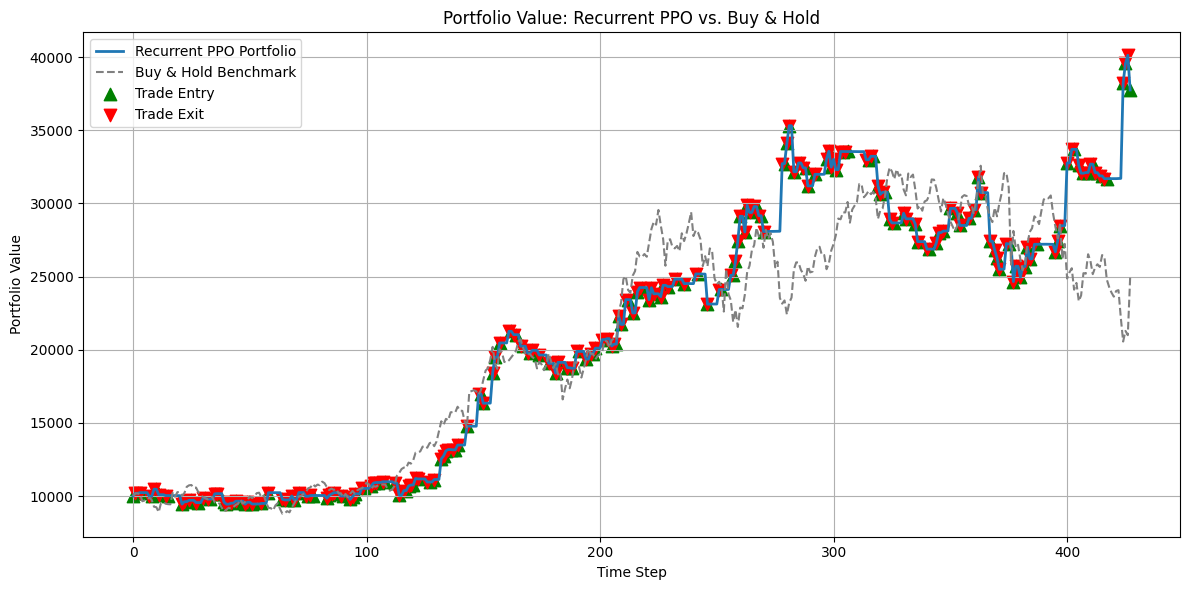

In [493]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

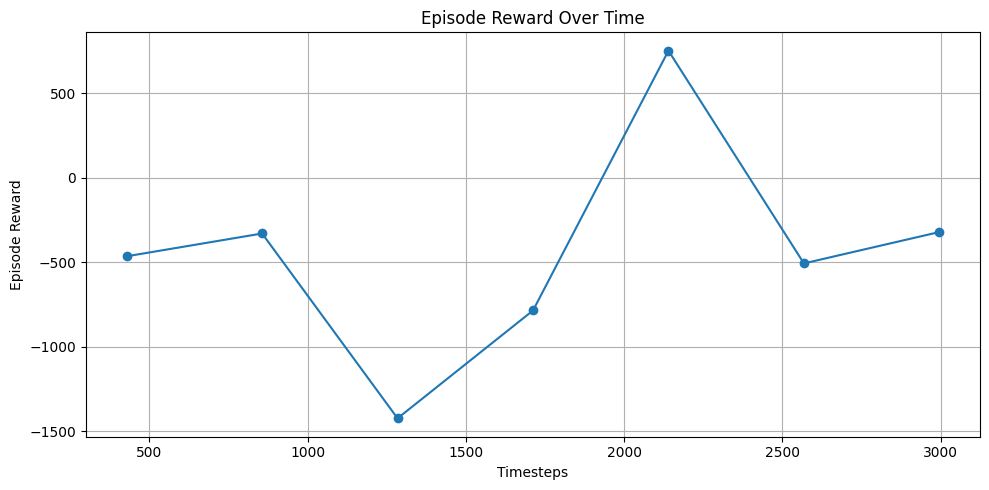

In [494]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

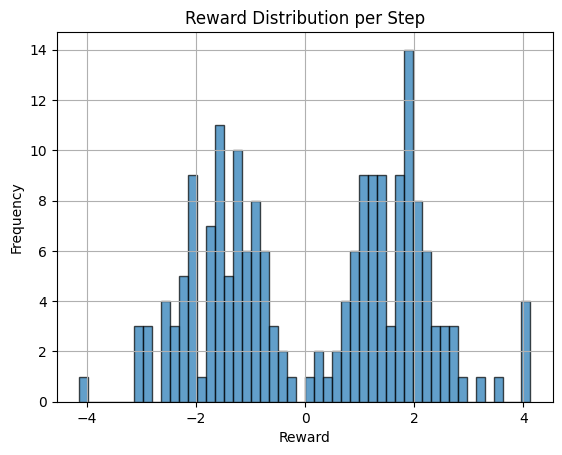

In [495]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

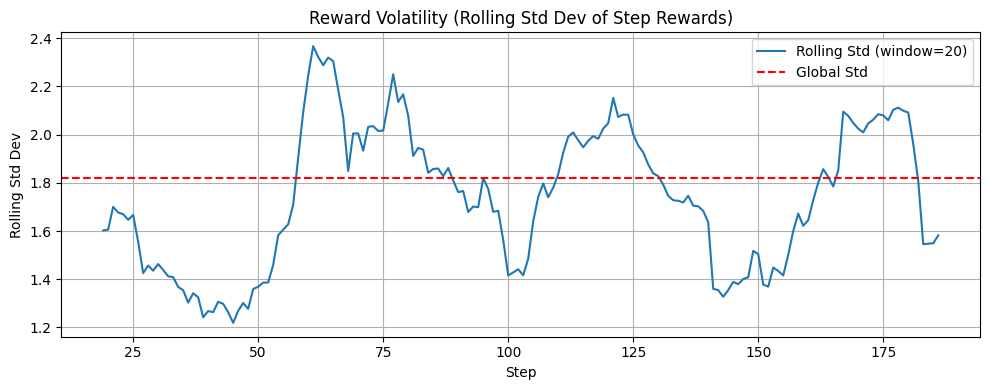

Mean Step Reward: 0.1547
Std Dev of Step Rewards: 1.8209
Variance: 3.3158
Range: 8.2692
Max Rolling Std (20): 2.3666
Min Rolling Std (20): 1.2189


In [496]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 175
Total Transitions: 174
Switches: 140
Switch Rate: 0.8046


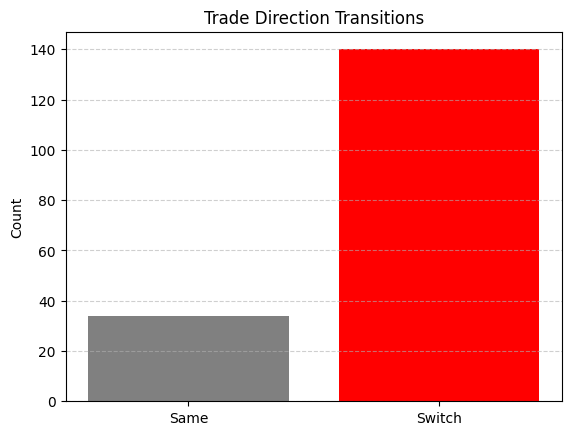

In [497]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

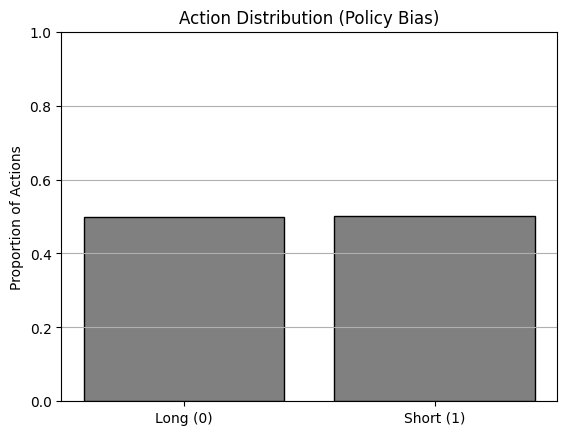

Long (0): Count = 213, Proportion = 49.77%
Short (1): Count = 215, Proportion = 50.23%


In [498]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")

--- Training with seed 71237 ---
Seed 71237: Reward = -8525.85, Final Balance = 3710.07
Average reward for action Long: 0.2432
Average reward for action Short: 0.0499
Best model updated and saved.

--- Training with seed 97600 ---
Seed 97600: Reward = -6433.13, Final Balance = 5881.59
Average reward for action Long: 0.2968
Average reward for action Short: -0.2705
Best model updated and saved.

--- Training with seed 95078 ---
Seed 95078: Reward = 5224.47, Final Balance = 17003.68
Average reward for action Long: 0.3283
Average reward for action Short: -0.2192
Best model updated and saved.

--- Training with seed 57246 ---
Seed 57246: Reward = -5768.96, Final Balance = 6495.31
Average reward for action Long: 0.3236
Average reward for action Short: -0.0896

--- Training with seed 44464 ---
Seed 44464: Reward = -5472.90, Final Balance = 6903.87
Average reward for action Long: 0.0069
Average reward for action Short: -0.1002

--- Training with seed 96800 ---
Seed 96800: Reward = -7142.38, Final Balance = 5208.52
Average reward for action Long: 0.1932
Average reward for action Short: -0.8241

--- Training with seed 52744 ---
Seed 52744: Reward = 1765.98, Final Balance = 13526.24
Average reward for action Long: 0.0640
Average reward for action Short: -0.3377

--- Training with seed 34500 ---
Seed 34500: Reward = 26026.52, Final Balance = 37747.27
Average reward for action Long: 0.4125
Average reward for action Short: -0.1004
Best model updated and saved.

--- Training with seed 40874 ---
Seed 40874: Reward = 5781.79, Final Balance = 17401.80
Average reward for action Long: 0.5544
Average reward for action Short: -0.3544

--- Training with seed 129147 ---
Seed 129147: Reward = -9030.47, Final Balance = 3400.98
Average reward for action Long: 0.3973
Average reward for action Short: -0.7070

--- Training with seed 71681 ---
Seed 71681: Reward = -7839.65, Final Balance = 4584.79
Average reward for action Long: 0.1000
Average reward for action Short: -0.1820

--- Seed Sweep Complete ---
Best Seed: 34500
Best Total Reward: 26026.52
Best Final Balance: 37747.27

In [499]:
model.save("NVDA_best_model")

## TSLA

In [570]:
from datetime import datetime, timedelta

# Add +1 day to end date
default_end_date = (datetime.now() + timedelta(days=1)).strftime("%Y-%m-%d")
default_start_date = (datetime.now() - timedelta(days=665)).strftime("%Y-%m-%d")

In [571]:
# Parameters
ticker = "TSLA"
start_date = default_start_date
end_date = default_end_date
data_filename = "full_data.csv"
signals_filename = "signals_data.csv"

save_historical_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    data_filename=data_filename,
    signals_filename=signals_filename
)

[*********************100%***********************]  1 of 1 completed


'Saved full_data.csv and signals_data.csv successfully.'

In [572]:
import pandas as pd

# Preview full data
df_full = pd.read_csv("full_data.csv", parse_dates=["Date"])
print(df_full.head())

# Preview signal data
df_signals = pd.read_csv("signals_data.csv", parse_dates=["Date"])
print(df_signals.head())

        Date       close        high         low        open     volume  \
0 2023-06-16  260.540009  263.600006  257.209991  258.920013  167563700   
1 2023-06-20  274.450012  274.750000  261.119995  261.500000  165611200   
2 2023-06-21  259.459991  276.989990  257.779999  275.130005  211797100   
3 2023-06-22  264.609985  265.000000  248.250000  250.770004  166875900   
4 2023-06-23  256.600006  262.450012  252.800003  259.290009  176584100   

       EMA_50     EMA_100     EMA_200     EMA_500  ...  RSI_Sell  MCDX_Buy  \
0  260.540009  260.540009  260.540009  260.540009  ...         1         0   
1  261.085499  260.815454  260.678417  260.595538  ...         0         0   
2  261.021753  260.788613  260.666293  260.591004  ...         1         0   
3  261.162468  260.864284  260.705534  260.607048  ...         1         0   
4  260.983548  260.779843  260.664683  260.591052  ...         1         0   

   MCDX_Sell  DSS_Buy  DSS_Sell  ZeroLag MACD_Buy  ZeroLag MACD_Sell  \
0       

In [573]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardTrackingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.timesteps = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None and any(self.locals["dones"]):
            ep_rew = self.locals["rewards"]
            self.episode_rewards.append(sum(ep_rew))
            self.timesteps.append(self.num_timesteps)
        return True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random

# --- Fixed Seed ---
SEED = 109961
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# --- Load & Clean Data ---
data_path = "full_data.csv"
data = pd.read_csv(data_path, parse_dates=["Date"])

required_cols = [
    'open', 'high', 'low', 'close',
    'zlma', 'ema_value',
    'DSSb', 'DSSsignal',
    'rsi_ma_base',
    'ZeroLagMACD', 'ZeroLagMACD_signal',
    'basicMACD', 'basicMACD_signal',
    'ZScore',
    'ZLMA_Buy', 'ZLMA_Sell',
    'RSI_Buy', 'RSI_Sell',
    'MCDX_Buy', 'MCDX_Sell',
    'DSS_Buy', 'DSS_Sell',
    'ZeroLag MACD_Buy', 'ZeroLag MACD_Sell',
    'Basic MACD_Buy', 'Basic MACD_Sell'
]

missing = [col for col in required_cols if col not in data.columns]
assert not missing, f"Missing required columns: {missing}"

data = data.dropna(subset=required_cols).reset_index(drop=True)

SWITCH_COST = 1.0
TRANSACTION_COST = 0.001

ACTIVATION = torch.nn.Tanh
# ACTIVATION = partial(nn.LeakyReLU, negative_slope=0.01)

policy_kwargs = dict(
    activation_fn=ACTIVATION
)

# --- Main Trading Environment ---
class TradingEnvRL(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, data, initial_balance=10000, hold_cost=0.02,
                 volatility_window=14, exploration_steps=500,
                 switch_cost=1.0, reentry_threshold=0.01,
                 dynamic_threshold=False, loss_penalty=0.75, drawdown_penalty=5.0, large_loss_threshold=-2.0):

        super().__init__()
        self.loss_penalty = loss_penalty
        self.drawdown_penalty = drawdown_penalty
        self.large_loss_threshold = large_loss_threshold
        self.data = data.reset_index(drop=True).copy()
        self.n_steps = len(self.data)
        self.initial_balance = initial_balance
        self.hold_cost = hold_cost
        self.volatility_window = volatility_window
        self.exploration_steps = exploration_steps
        self.switch_cost = switch_cost
        self.reentry_threshold = reentry_threshold
        self.dynamic_threshold = dynamic_threshold
        self.step_rewards = []

        self.feature_cols = [
            'open', 'high', 'low', 'close',
            'basicMACD', 'basicMACD_signal',
            'Basic MACD_Buy', 'Basic MACD_Sell'
        ]

        obs_dim = len(self.feature_cols) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=Long, 1=Short

        self._compute_volatility_limit()

    def _compute_volatility_limit(self):
        returns = self.data['close'].pct_change()
        self.data['volatility'] = returns.rolling(self.volatility_window).std()
        self.data['adaptive_hold'] = (10 / (self.data['volatility'] * 100)).clip(lower=3, upper=20).fillna(10).astype(int)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)

        self.current_step = 0
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0
        self.switch_count = 0
        self.balance = self.initial_balance
        self.cumulative_pnl = 0.0
        self.trade_log = []
        self.action_counts = {0: 0, 1: 0}
        self.reward_tracker = {0: [], 1: []}
        self.consecutive_losses = 0
        self.equity_curve = [self.initial_balance]
        self.step_rewards = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32)
        pos_feature = np.array([self.position], dtype=np.float32)
        return np.concatenate([features, pos_feature])

    def _force_close(self):
        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.position == 0:
            return 0.0

        # --- Core Return Logic ---
        trade_pct = ((current_price / self.entry_price - 1) * 100) if self.position == 1 else ((self.entry_price / current_price - 1) * 100)
        pos_str = 'Long' if self.position == 1 else 'Short'
        gross_return = trade_pct / 100
        transaction_cost = TRANSACTION_COST * current_price

        old_balance = self.balance
        self.balance -= transaction_cost
        self.balance *= (1 + gross_return)
        net_profit = self.balance - old_balance

        reward = net_profit

        # --- Track Trade History ---
        self.cumulative_pnl += trade_pct
        compounded_pnl = (self.trade_log[-1]['CompoundedFactor'] * (1 + gross_return)) if self.trade_log else (1 + gross_return)
        compounded_pnl_pct = (compounded_pnl - 1) * 100

        self.trade_log.append({
            'EntryDate': self.entry_date,
            'ExitDate': current_date,
            'Position': pos_str,
            'EntryPrice': round(self.entry_price, 4),
            'ExitPrice': round(current_price, 4),
            'PnL%': round(trade_pct, 2),
            'CumulativePnL%': round(self.cumulative_pnl, 2),
            'CompoundedFactor': compounded_pnl,
            'CompoundedPnL%': round(compounded_pnl_pct, 2)
        })

        # --- Penalty for Large Loss ---
        if trade_pct < -2.0:
            reward += trade_pct * 2  # Stronger penalty for large loss

        # --- Track & Penalize Consecutive Losses ---
        if trade_pct < 0:
            self.consecutive_losses += 1
            reward -= self.consecutive_losses * 0.75  # Growing penalty
        else:
            self.consecutive_losses = 0

        # --- Optional: Drawdown Penalty ---
        self.equity_curve.append(self.balance)
        max_balance = max(self.equity_curve)
        if max_balance > 0:
            drawdown = (max_balance - self.balance) / max_balance
            reward -= 5.0 * drawdown  # Penalize deeper drawdown

        # --- Reset State ---
        self.position = 0
        self.entry_price = 0.0
        self.entry_date = None
        self.hold_counter = 0

        return reward

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action.item())

        row = self.data.iloc[self.current_step]
        current_price = float(row['close'])
        current_date = row['Date'].strftime("%Y-%m-%d")

        if self.current_step < self.exploration_steps:
            action = self.action_space.sample()

        self.action_counts[action] += 1
        reward = 0.0
        target_position = 1 if action == 0 else -1

        # === Holding Same Position ===
        if self.position == target_position:
            self.hold_counter += 1
            price_change = (current_price - self.entry_price) / self.entry_price
            step_return = price_change if self.position == 1 else -price_change

            step_reward = np.sign(step_return) * np.sqrt(abs(step_return)) * 10
            step_reward = np.clip(step_reward, -50, 50)
            step_reward -= self.hold_cost
            reward += step_reward
            self.reward_tracker[action].append(step_reward)
            self.step_rewards.append(reward)

        # === New Position from Flat ===
        elif self.position == 0:
            self.position = target_position
            self.entry_price = current_price
            self.entry_date = current_date
            self.hold_counter = 1
            reward -= TRANSACTION_COST * current_price

        # === Switch Position ===
        else:
            hold_penalty = max(0, 3 - self.hold_counter) * 5.0
            switch_penalty = self.switch_cost + hold_penalty
            reward += self._force_close()
            reward -= switch_penalty

            # === Dynamic Re-entry Threshold ===
            if self.current_step > 0:
                prev_close = self.data.iloc[self.current_step - 1]['close']
                recent_return = abs((current_price - prev_close) / prev_close)

                # Volatility-aware reentry threshold
                recent_volatility = row['volatility']
                reentry_threshold = 0.5 * recent_volatility
            else:
                recent_return = 0
                reentry_threshold = 0.01  # Fallback

            if recent_return > reentry_threshold:
                self.position = target_position
                self.entry_price = current_price
                self.entry_date = current_date
                self.hold_counter = 1
                reward -= TRANSACTION_COST * current_price

        self.current_step += 1
        terminated = self.current_step >= self.n_steps - 1

        if terminated and self.position != 0:
            reward += self._force_close()

        obs = self._get_obs() if not terminated else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, terminated, False, {}

    def render(self):
        print(f"Step: {self.current_step}, Position: {self.position}, Balance: {self.balance:.2f}")

    def save_trade_log(self, filename="trade_log.csv"):
        df = pd.DataFrame(self.trade_log)
        if "CompoundedFactor" in df.columns:
            df = df.drop(columns=["CompoundedFactor"])
        df.to_csv(filename, index=False)

# --- Training ---
env = TradingEnvRL(data, initial_balance=10000)
vec_env = DummyVecEnv([lambda: env])
vec_env.seed(SEED)

model = RecurrentPPO(
    policy=MlpLstmPolicy,
    env=vec_env,
    verbose=1,
    n_steps=64,
    batch_size=32,
    learning_rate=0.01,
    gamma=0.99,
    ent_coef=0.01,
    seed=SEED,
    policy_kwargs=policy_kwargs
)

callback = RewardTrackingCallback()

model.learn(total_timesteps=3000, callback=callback)
print(f"\nTraining Complete")

In [575]:
# --- Evaluation ---
obs, _ = env.reset()
state = None
done = False
total_reward = 0
portfolio_values = []
final_action = None

while not done:
    action, state = model.predict(obs, state=state, deterministic=True)
    final_action = action
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    current_index = min(env.current_step, len(env.data) - 1)
    current_price = env.data.loc[current_index, 'close']
    unrealized = (
        (current_price - env.entry_price) if env.position == 1 else
        (env.entry_price - current_price) if env.position == -1 else
        0.0
    )
    mtm_equity = env.balance + unrealized
    portfolio_values.append(mtm_equity)

# --- Save trade log ---
env.save_trade_log("trade_log_recurrent.csv")

# --- Final Model Signal ---
signal_str = "BUY" if final_action == 0 else "SELL"
latest_date = env.data['Date'].iloc[env.current_step - 1].strftime("%Y-%m-%d")
print(f"\nLatest model signal at {latest_date}: {signal_str}")

# --- Summary Output ---
print(f"Total Reward: {total_reward:.2f}")
print(f"Final Balance: {env.balance:.2f}")
print("Trade Log (Recurrent PPO):")
print(pd.DataFrame(env.trade_log))
print("Action counts:", env.action_counts)
print("Average reward per action:")
for k, v in env.reward_tracker.items():
    mean_r = np.mean(v) if v else 0
    print(f"Action {k} ({'Long' if k==0 else 'Short'}): {mean_r:.4f}")


Latest model signal at 2025-04-09: BUY
Total Reward: 10069.41
Final Balance: 22325.22
Trade Log (Recurrent PPO):
      EntryDate    ExitDate Position  EntryPrice  ExitPrice   PnL%  \
0    2023-07-27  2023-07-28     Long      255.71     266.44   4.20   
1    2023-07-31  2023-08-01    Short      267.43     261.07   2.44   
2    2023-08-02  2023-08-04     Long      254.11     253.86  -0.10   
3    2023-08-07  2023-08-08     Long      251.45     249.70  -0.70   
4    2023-08-09  2023-08-10    Short      242.19     245.34  -1.28   
..          ...         ...      ...         ...        ...    ...   
186  2025-04-01  2025-04-03     Long      268.46     267.28  -0.44   
187  2025-04-03  2025-04-04    Short      267.28     239.43  11.63   
188  2025-04-04  2025-04-07     Long      239.43     233.29  -2.56   
189  2025-04-08  2025-04-09     Long      221.86     272.20  22.69   
190  2025-04-09  2025-04-10    Short      272.20     252.40   7.84   

     CumulativePnL%  CompoundedFactor  Compou

In [576]:
# --- Get Latest Signal from Model ---
last_index = len(env.data) - 1
env.current_step = last_index
obs = env._get_obs()

# Add batch dimension and run prediction
obs_input = obs[np.newaxis, :]
action, _ = model.predict(obs_input, deterministic=True)

# Convert action to trading signal
# 0 = Long => BUY, 1 = Short => SELL
if action == 0:
    current_signal = "BUY"
else:
    current_signal = "SELL"

print(f"\nLatest model signal at {env.data.iloc[last_index]['Date'].date()}: {current_signal}")


Latest model signal at 2025-04-10: BUY


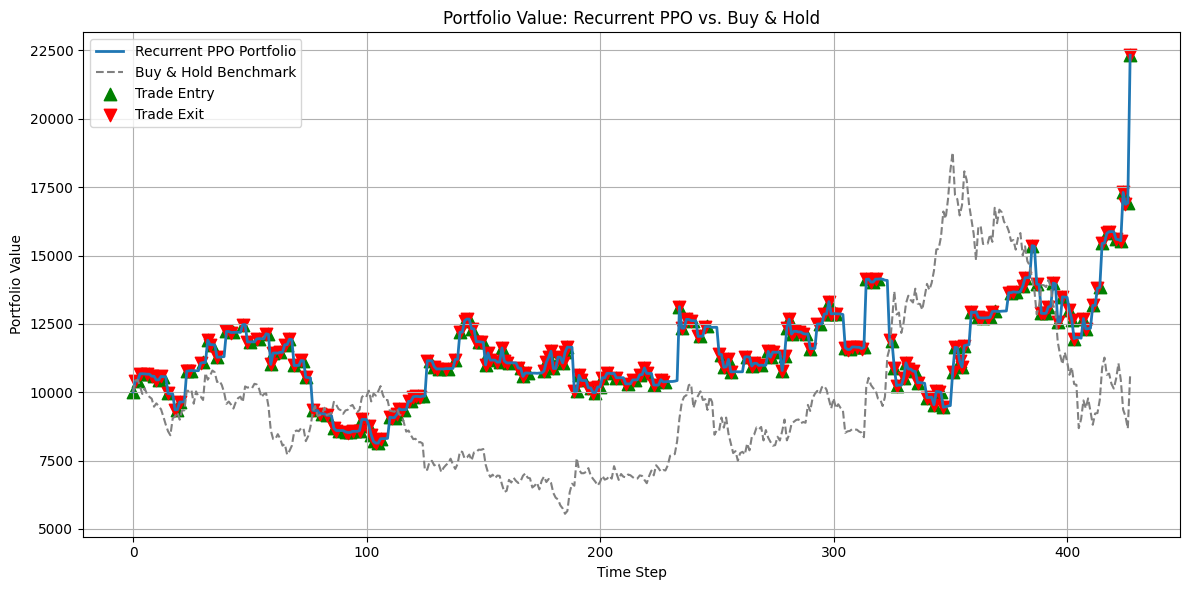

In [577]:
# --- Plot Performance with Trade Markers ---
buy_hold_line = [env.initial_balance * (p / data['close'].iloc[0]) for p in data['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

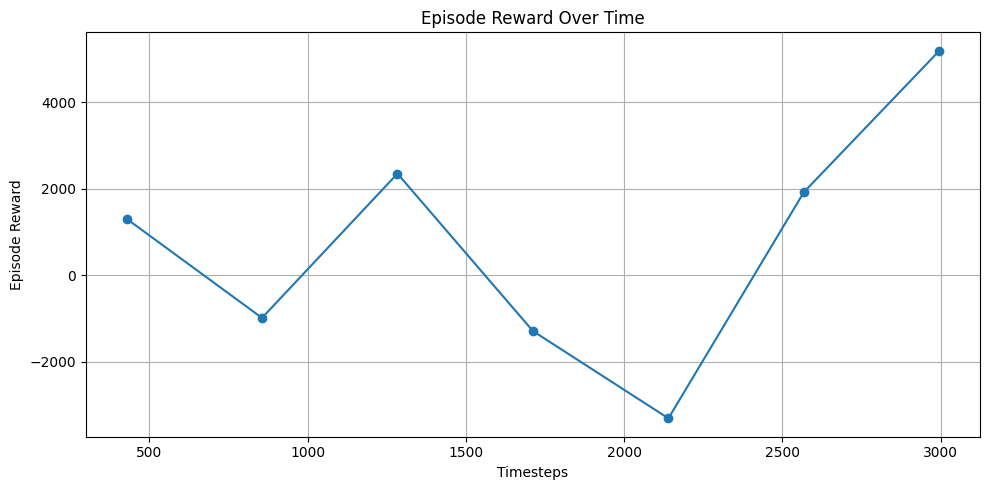

In [578]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(callback.timesteps, callback.episode_rewards, marker='o')
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

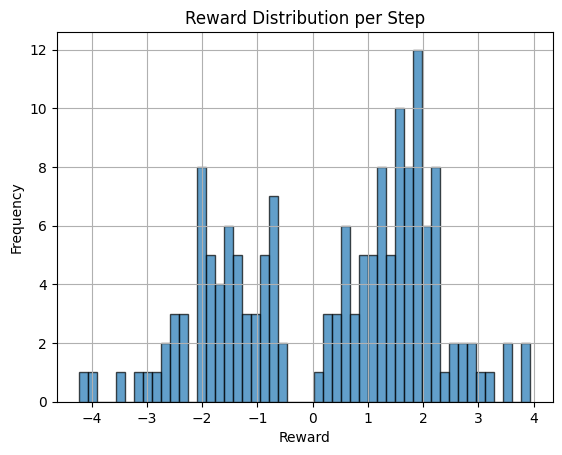

In [579]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rewards = np.array(env.step_rewards)

# Histogram
plt.hist(rewards, bins=50, alpha=0.7, edgecolor='black')
plt.title("Reward Distribution per Step")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

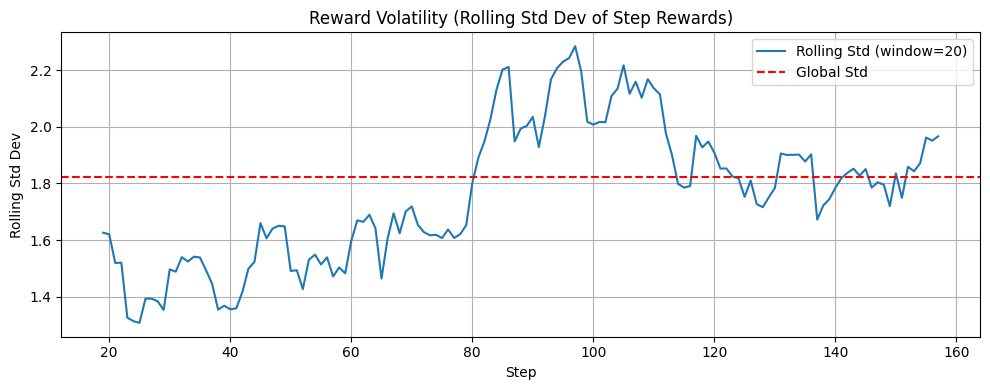

Mean Step Reward: 0.3273
Std Dev of Step Rewards: 1.8234
Variance: 3.3247
Range: 8.1576
Max Rolling Std (20): 2.2853
Min Rolling Std (20): 1.3074


In [580]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rewards = np.array(env.step_rewards)

# --- Raw volatility metrics ---
reward_std = np.std(rewards)
reward_mean = np.mean(rewards)
reward_variance = np.var(rewards)
reward_range = np.max(rewards) - np.min(rewards)

# --- Rolling volatility ---
window = 20
rolling_std = pd.Series(rewards).rolling(window=window).std()

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(rolling_std, label=f"Rolling Std (window={window})")
plt.axhline(reward_std, color='red', linestyle='--', label='Global Std')
plt.title("Reward Volatility (Rolling Std Dev of Step Rewards)")
plt.xlabel("Step")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Output stats ---
print(f"Mean Step Reward: {reward_mean:.4f}")
print(f"Std Dev of Step Rewards: {reward_std:.4f}")
print(f"Variance: {reward_variance:.4f}")
print(f"Range: {reward_range:.4f}")
print(f"Max Rolling Std ({window}): {rolling_std.max():.4f}")
print(f"Min Rolling Std ({window}): {rolling_std.min():.4f}")

Total Trades: 191
Total Transitions: 190
Switches: 149
Switch Rate: 0.7842


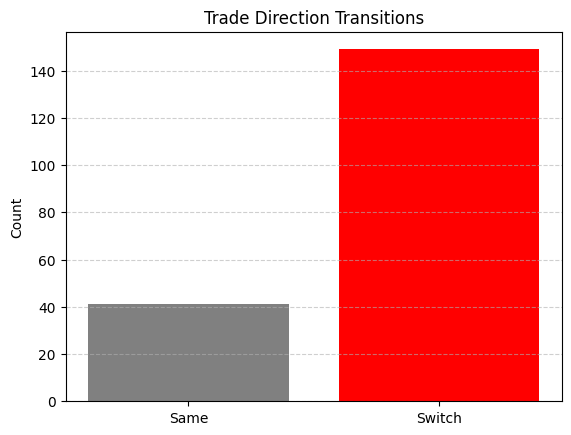

In [581]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_switch_rate(trade_log: pd.DataFrame, plot: bool = True):
    if 'Position' not in trade_log.columns or trade_log.empty:
        raise ValueError("Trade log must contain a 'Position' column and be non-empty.")

    positions = trade_log['Position'].tolist()
    if len(positions) < 2:
        print("Insufficient trades to compute switching behavior.")
        return 0.0

    switches = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i - 1])
    total_transitions = len(positions) - 1
    switch_rate = switches / total_transitions

    print(f"Total Trades: {len(positions)}")
    print(f"Total Transitions: {total_transitions}")
    print(f"Switches: {switches}")
    print(f"Switch Rate: {switch_rate:.4f}")

    if plot:
        plt.bar(['Same', 'Switch'], [total_transitions - switches, switches], color=['gray', 'red'])
        plt.title("Trade Direction Transitions")
        plt.ylabel("Count")
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.show()

    return switch_rate

df_trades = pd.DataFrame(env.trade_log)
switch_rate = compute_switch_rate(df_trades)

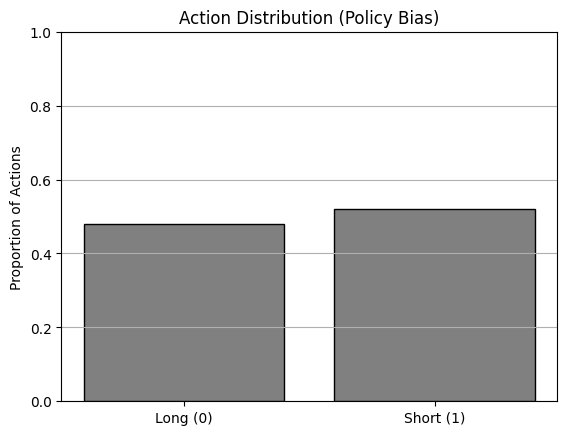

Long (0): Count = 205, Proportion = 47.90%
Short (1): Count = 223, Proportion = 52.10%


In [582]:
import matplotlib.pyplot as plt

total_actions = sum(env.action_counts.values())

actions = list(env.action_counts.keys())
counts = [env.action_counts[a] for a in actions]
labels = ['Long (0)', 'Short (1)']

proportions = [count / total_actions for count in counts]

plt.bar(labels, proportions, color='gray', edgecolor='black')
plt.title("Action Distribution (Policy Bias)")
plt.ylabel("Proportion of Actions")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

for label, count, prop in zip(labels, counts, proportions):
  print(f"{label}: Count = {count}, Proportion = {prop:.2%}")

--- Training with seed 84511 ---
Seed 84511: Reward = -69.15, Final Balance = 12038.12
Average reward for action Long: 0.3914
Average reward for action Short: -0.5380
Best model updated and saved.

--- Training with seed 97974 ---
Seed 97974: Reward = -9070.66, Final Balance = 3522.30
Average reward for action Long: 0.0136
Average reward for action Short: -0.0997

--- Training with seed 64982 ---
Seed 64982: Reward = 7790.18, Final Balance = 19863.73
Average reward for action Long: -0.2441
Average reward for action Short: 0.6258
Best model updated and saved.

--- Training with seed 62977 ---
Seed 62977: Reward = 2570.52, Final Balance = 14840.80
Average reward for action Long: 0.4955
Average reward for action Short: -0.5567

--- Training with seed 111581 ---
Seed 111581: Reward = -6663.71, Final Balance = 5529.87
Average reward for action Long: -0.0897
Average reward for action Short: -0.0450

--- Training with seed 43633 ---
Seed 43633: Reward = -4373.75, Final Balance = 8066.42
Average reward for action Long: -0.0223
Average reward for action Short: 0.1117

--- Training with seed 110692 ---
Seed 110692: Reward = 3013.97, Final Balance = 15078.01
Average reward for action Long: -0.2785
Average reward for action Short: 0.6881

--- Training with seed 65785 ---
Seed 65785: Reward = 2912.61, Final Balance = 15068.03
Average reward for action Long: 0.2839
Average reward for action Short: 0.2509

--- Training with seed 94074 ---
Seed 94074: Reward = -4182.82, Final Balance = 8117.05
Average reward for action Long: -0.0971
Average reward for action Short: -0.4204

--- Training with seed 38615 ---
Seed 38615: Reward = -3628.04, Final Balance = 8626.54
Average reward for action Long: -0.6513
Average reward for action Short: -0.1777

--- Training with seed 109961 ---
Seed 109961: Reward = 10069.41, Final Balance = 22325.22
Average reward for action Long: 0.4063
Average reward for action Short: 0.2677
Best model updated and saved.

--- Seed Sweep Complete ---
Best Seed: 109961
Best Total Reward: 10069.41
Best Final Balance: 22325.22

In [583]:
model.save("TSLA_best_model")

## Model Inference Run 1 (NVDA)

Inference determinism test, run this and below to compare.


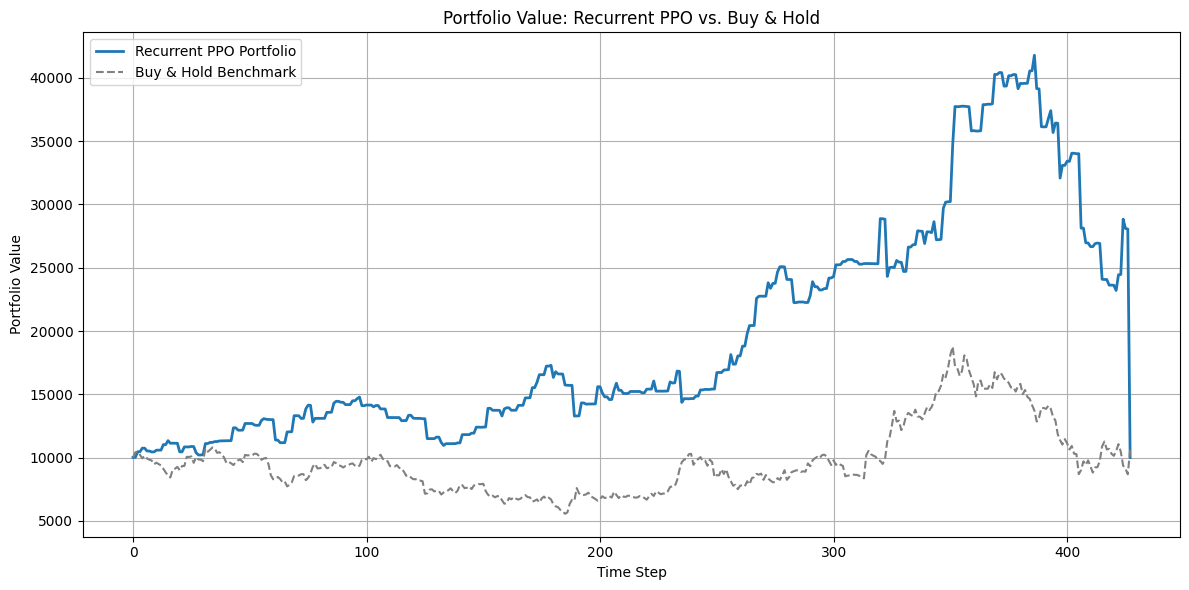

Inference completed in 428 steps.
Total reward accumulated: 12608.24
Final model signal: BUY


In [612]:
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

# === Recreate environment ===
inference_env = DummyVecEnv([lambda: TradingEnvRL(data, initial_balance=10000)])

# === Load model ===
model = RecurrentPPO.load("NVDA_best_model", env=inference_env)

# === Inference Setup ===
obs = inference_env.reset()
lstm_states = None
episode_starts = np.ones((inference_env.num_envs,), dtype=bool)
done = [False]
total_reward = 0.0
step_count = 0
portfolio_values = []

env = inference_env.envs[0]  # Unwrapped env
data_used = env.data
last_action = None  # Track final signal

# === Inference Loop ===
while not done[0]:
    action, lstm_states = model.predict(
        obs,
        state=lstm_states,
        episode_start=episode_starts,
        deterministic=True
    )
    obs, reward, done, info = inference_env.step(action)
    episode_starts = done
    total_reward += reward[0]
    step_count += 1
    last_action = action[0]  # Capture the final action taken

    # Track portfolio value (mark-to-market)
    idx = min(env.current_step, len(data_used) - 1)
    price_now = data_used.loc[idx, 'close']
    unrealized = (
        (price_now - env.entry_price) if env.position == 1 else
        (env.entry_price - price_now) if env.position == -1 else
        0.0
    )
    portfolio_values.append(env.balance + unrealized)

# === Save trades ===
env.save_trade_log("inference_trades.csv")

# === Plot performance ===
buy_hold_line = [env.initial_balance * (p / data_used['close'].iloc[0]) for p in data_used['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data_used.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

# === Print summary ===
signal_map = {0: "BUY", 1: "SELL"}
latest_signal = signal_map.get(last_action, "UNKNOWN")
print(f"Inference completed in {step_count} steps.")
print(f"Total reward accumulated: {total_reward:.2f}")
print(f"Final model signal: {latest_signal}")

## Model Inference Run 2 (NVDA)

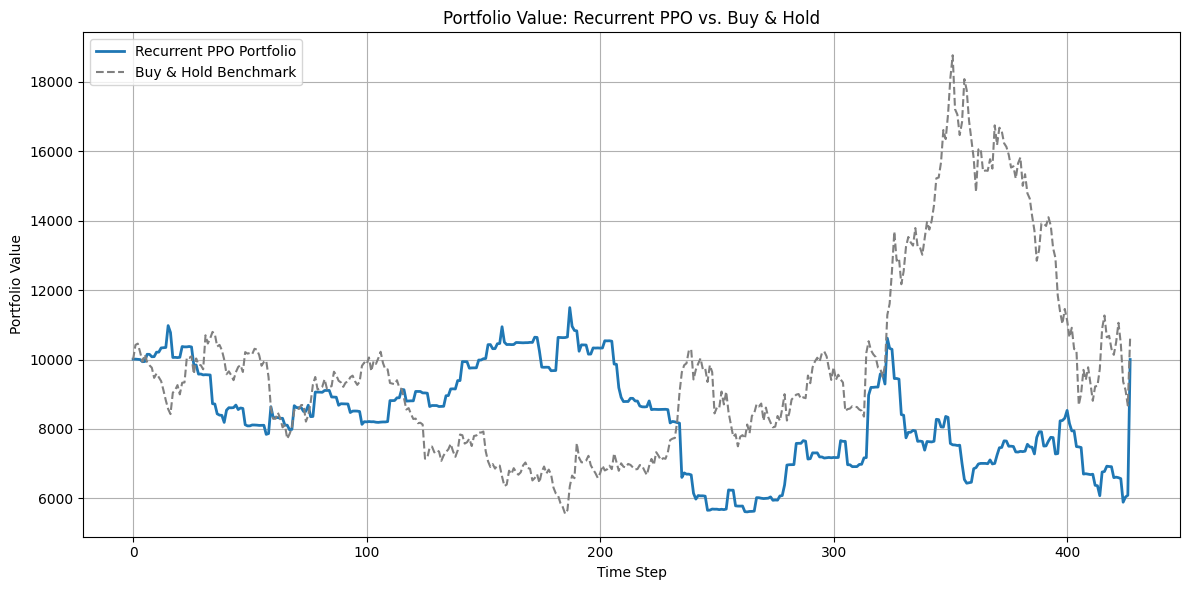

Inference completed in 428 steps.
Total reward accumulated: -4407.63
Final model signal: BUY


In [613]:
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv

# === Recreate environment ===
inference_env = DummyVecEnv([lambda: TradingEnvRL(data, initial_balance=10000)])

# === Load model ===
model = RecurrentPPO.load("NVDA_best_model", env=inference_env)

# === Inference Setup ===
obs = inference_env.reset()
lstm_states = None
episode_starts = np.ones((inference_env.num_envs,), dtype=bool)
done = [False]
total_reward = 0.0
step_count = 0
portfolio_values = []

env = inference_env.envs[0]  # Unwrapped env
data_used = env.data
last_action = None  # Track final signal

# === Inference Loop ===
while not done[0]:
    action, lstm_states = model.predict(
        obs,
        state=lstm_states,
        episode_start=episode_starts,
        deterministic=True
    )
    obs, reward, done, info = inference_env.step(action)
    episode_starts = done
    total_reward += reward[0]
    step_count += 1
    last_action = action[0]  # Capture the final action taken

    # Track portfolio value (mark-to-market)
    idx = min(env.current_step, len(data_used) - 1)
    price_now = data_used.loc[idx, 'close']
    unrealized = (
        (price_now - env.entry_price) if env.position == 1 else
        (env.entry_price - price_now) if env.position == -1 else
        0.0
    )
    portfolio_values.append(env.balance + unrealized)

# === Save trades ===
env.save_trade_log("inference_trades.csv")

# === Plot performance ===
buy_hold_line = [env.initial_balance * (p / data_used['close'].iloc[0]) for p in data_used['close'].iloc[:len(portfolio_values)]]

date_to_step = {row['Date'].strftime('%Y-%m-%d'): i for i, row in data_used.iloc[:len(portfolio_values)].iterrows()}
entry_points = []
exit_points = []

for trade in env.trade_log:
    entry_step = date_to_step.get(trade['EntryDate'])
    exit_step = date_to_step.get(trade['ExitDate'])
    if entry_step is not None and entry_step < len(portfolio_values):
        entry_points.append((entry_step, portfolio_values[entry_step]))
    if exit_step is not None and exit_step < len(portfolio_values):
        exit_points.append((exit_step, portfolio_values[exit_step]))

plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label="Recurrent PPO Portfolio", linewidth=2)
plt.plot(buy_hold_line, label="Buy & Hold Benchmark", linestyle="--", color="gray")

if entry_points:
    entry_steps, entry_vals = zip(*entry_points)
    plt.scatter(entry_steps, entry_vals, color='green', marker='^', s=80, label="Trade Entry")
if exit_points:
    exit_steps, exit_vals = zip(*exit_points)
    plt.scatter(exit_steps, exit_vals, color='red', marker='v', s=80, label="Trade Exit")

plt.title("Portfolio Value: Recurrent PPO vs. Buy & Hold")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("recurrent_ppo_performance.png")
plt.show()

# === Print summary ===
signal_map = {0: "BUY", 1: "SELL"}
latest_signal = signal_map.get(last_action, "UNKNOWN")
print(f"Inference completed in {step_count} steps.")
print(f"Total reward accumulated: {total_reward:.2f}")
print(f"Final model signal: {latest_signal}")

## Changelog

### Version 2.8.0
- Added more statistical metrics
- Code cleanup
- Clearer notebook organization
- Added model inference

### 2.5.0
- Updated model rules and tests

### 2.2.0
- Added per model saving
- Split entry points from Gradio
- Organization cleanup

### 2.1.0
- New major features: Recurrent PPO module training, seed search, and portfolio performance testing
- Removed DQN module
- Improved CSV saving function

### 1.2.3
- Adjusted default weights

### 1.2.2
- Fixed trade table
- Minor formatting

### 1.2.1
- Added trade table
- Added user adjustable weights
- Added basic MACD
- Added trade signals